# Machine Learning Analysis

## Import modules and clean data

In [1]:
# run the data story to get data wrangling and data story variables
%run ./data_story.ipynb

E-Bikes dropped: 338834
Original scooter entries: 6510117
NA rows dropped: 130
Out of Bounds entries dropped: 52981
Before removing outliers:


<Figure size 1000x500 with 2 Axes>

Negative duration dropped: 1028
Over 12.0 hours dropped: 262
Negative or 0 distance dropped: 505391
Distance > 49.9999845312 mi dropped: 965
After removing outliers:


<Figure size 1000x500 with 2 Axes>

Total entries remaining: 5949360
Percent removed: 8.61362399477613%
Column Data types:
Device ID                           object
Vehicle Type                      category
Trip Duration                      float64
Trip Distance                      float64
Start Time                  datetime64[ns]
End Time                    datetime64[ns]
Modified Date               datetime64[ns]
Month                                 int8
Hour                                  int8
Day of Week                           int8
Council District (Start)           float64
Council District (End)             float64
Year                                 int16
Census Tract Start                  object
Census Tract End                    object
dtype: object


<Figure size 1000x500 with 2 Axes>

<Figure size 640x480 with 1 Axes>

Number of Census Tract Starts: 256
Number of Census Tract Ends: 257
Number of unique Census Tracts in the data: 271


<Figure size 640x480 with 1 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 640x480 with 1 Axes>

Top 4 starting location counts by day:


<Figure size 1000x500 with 4 Axes>

Top 4 ending location counts by day:


<Figure size 1000x500 with 4 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

<Figure size 1500x1500 with 2 Axes>

In [2]:
# import modules
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
import datetime as dt
from sklearn.metrics import r2_score

## Prepare data for prediction

The function below was created to generate the number of rides in a census tract per hour.  Then the date columns can be used as features, and the number of rides as target.

In [53]:
# create a row for every hour
def ct_by_hour(df, census_tract, sample='H', end=False):
    '''Returns dataframe with the number of rides per hour
    df: DataFrame--the source DataFrame (i.e. scooters)
    census_tract: String--the census tract number
    sample: String--the desired sample rate (see pandas.DataFrame.resample documentation)
    end: boolean--If true, use census tract end for resampling'''
    
    if end:
        ct_df = pd.DataFrame(df[df['Census Tract End']==census_tract])
    else:
        ct_df = pd.DataFrame(df[df['Census Tract Start']==census_tract])
    
    # add a n column to sample
    ct_df['n'] = 1
    
    # resample at sample rate.  Use mean for distance/duration.  Also use mean to preserve datetime related values.
    # Use sum for n
    ct_df = ct_df.set_index('Start Time').resample(sample).agg({'Trip Duration': np.mean, 
                                                               'Trip Distance': np.mean,
                                                               'Month': np.mean,
                                                               'Day of Week': np.mean,
                                                               'Hour': np.mean,
                                                               'Year': np.mean,
                                                               'n': np.sum})
    
    
    # drop nas
    ct_df = ct_df.dropna()
    
    # Add day of month
    ct_df['Day of Year'] = ct_df.index.dayofyear
    
    # Return date and time columns.  Don't use duration and distance, as they would make better targets
    return ct_df[['Year', 'Day of Year', 'Day of Week', 'Hour', 'n']]


## Linear and Ridge Regression

In [59]:
def run_regression(regressor, census_tract, source_df=scooters, sample_rate='H'):
    '''Runs desired regression on the specified census tract. Plots results and prints score
    Classifier: desired sklearn classifier
    census_tract: string--census tract number
    source_df: DataFrame--source dataframe, default is scooters'''
    
    # Create features and target
    df = ct_by_hour(source_df, census_tract, sample=sample_rate)
    

    X = df[['Year', 'Day of Year', 'Day of Week', 'Hour']]
    y = df['n']

    # Split into test and training data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    

    # Fit classifier to training data
    regressor.fit(X_train, y_train)

    # Predict on test data
    y_pred_reg = regressor.predict(X_test)

    plt.figure(figsize=(10, 5))
    
    plt.scatter(y_test, y_pred_reg)
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.plot([0, 750], [0, 750], '--k')

    plt.tight_layout()
    plt.show()
    plt.close()

    print(f'Confidence score of {r2_score(y_test, y_pred_reg)} \n')
    
    return regressor, X, y

In [5]:
def mape_error(y_actual, y_pred):
    mape = np.sum(abs(y_actual - y_pred) / abs(y_actual)) / len(y_actual)
    return mape

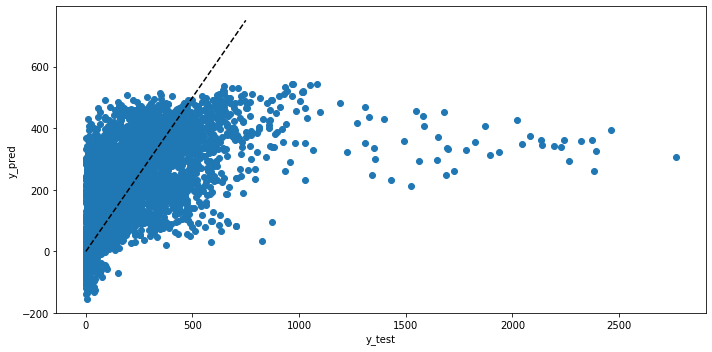

Confidence score of 0.27801549939689374 



0
Year         219.320397
Day of Year    0.413987
Day of Week   17.178929
Hour          15.277765

In [6]:
# Run a linear regression on the most popular census tract
linreg, linreg_X, linreg_y= run_regression(LinearRegression(), '48453001100');

# print the coefficients 
pd.DataFrame(linreg.coef_, linreg_X.columns)

Running the Linear Regression as in the code above produces a dismal r2 score of .28.

### One Hot Encoding

Use a One Hot Encoder to expand the date features into categorical data.  The function below creates a One Hot Encoder to split the categories into Year, Day of Year, Day of Week, and Hour.

In [72]:
def expanded_linreg(ct, sample_rate='H'):
    # Create features and target
    if sample_rate == 'D':
        df = ct_by_hour(scooters, ct, sample='D')
        X = df[['Year', 'Day of Year', 'Day of Week']]
        y = df['n']
    else:
        df = ct_by_hour(scooters, ct)
        X = df[['Year', 'Day of Year', 'Day of Week', 'Hour']]
        y = df['n']
    # initiate a OneHotEncoder to transform X into categorical data.
    ohe = OneHotEncoder(categories='auto')


    # fit transform the ohe to create a categorical X
    X_vectorized = ohe.fit_transform(X).toarray()

    # Split into test and training data
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.4, random_state=42)

    # Fit classifier to training data
    # Using Linear regression 
    reg = LinearRegression()
    reg.fit(X_train, y_train)

    # Predict on test data
    y_pred = reg.predict(X_test)
    print(max(y_pred))
    print(max(y_test))

    plt.subplot(1,2,1)
    plt.scatter(y_test, y_pred)
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.plot([0, max(y_pred)], [0, max(y_pred)], '--k')
    plt.title(str(reg))
    
    # revert the x_test back to dates to plot
    if sample_rate == 'D':
        X_test_dates = pd.DataFrame(ohe.inverse_transform(X_test), columns=['year', 'day of year', 'day of week'])
        X_test_dates['month'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%m')
        X_test_dates['day'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%d')
        X_test_dates = pd.to_datetime(X_test_dates[['year', 'month', 'day']])
    else:
        X_test_dates = pd.DataFrame(ohe.inverse_transform(X_test), columns=['year', 'day of year', 'day of week', 'hour'])
        X_test_dates['month'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%m')
        X_test_dates['day'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%d')
        X_test_dates = pd.to_datetime(X_test_dates[['year', 'month', 'day', 'hour']])
    
    
    plt.subplot(1,2,2)
    plt.scatter(X_test_dates, y_pred, color='b', alpha=0.5, label='y predicted')
    plt.scatter(X_test_dates, y_test, color='r', alpha=0.5, label='y test')
    plt.xticks(rotation=90)
    plt.legend()
    #plt.xlim(dt.date(2019, 6, 1), dt.date(2019, 6, 14))
    plt.xlabel('Date')
    plt.ylabel('Number of Rides')
    
    
    plt.show()
    plt.close()

    print(f'Confidence score for categorical X with Linear Regression: {r2_score(y_test, y_pred)}')
    print(f'MAPE: {mape_error(y_test, y_pred)}')
    
    if sample_rate == 'D':
        coeff = pd.DataFrame(reg.coef_, 
                             ohe.get_feature_names(['year', 'Day of Year', 'day of week']), 
                             columns=['Coefficient'])
    
    else:
        coeff = pd.DataFrame(reg.coef_, 
                             ohe.get_feature_names(['year', 'Day of Year', 'day of week', 'hour']), 
                             columns=['Coefficient'])
    return reg, coeff

6.49216466899346e+17
23594


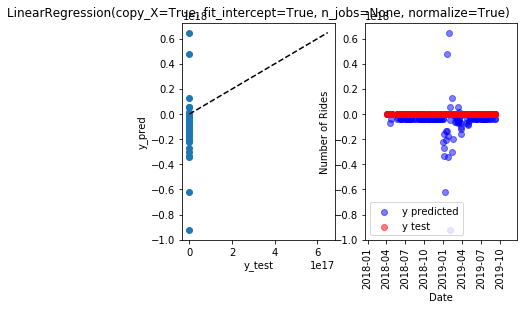

Confidence score for categorical X with Linear Regression: -8.153509974161747e+26
MAPE: 21009975287471.242
                  Coefficient
year_2018.0      1.043224e+16
year_2019.0      1.043224e+16
Day of Year_1   -1.869714e+17
Day of Year_2   -2.327409e+17
Day of Year_3   -1.232105e+17
Day of Year_4    3.573956e+16
Day of Year_5    3.573956e+16
Day of Year_6   -3.002577e+17
Day of Year_7    3.573956e+16
Day of Year_8   -5.863357e+17
Day of Year_9    3.573956e+16
Day of Year_10   3.573956e+16
Day of Year_11   3.573956e+16
Day of Year_12   3.573956e+16
Day of Year_13   3.573956e+16
Day of Year_14  -1.725905e+17
Day of Year_15  -9.679037e+16
Day of Year_16   3.573956e+16
Day of Year_17   3.573956e+16
Day of Year_18   3.573956e+16
Day of Year_19  -9.717823e+16
Day of Year_20   3.573956e+16
Day of Year_21   5.132834e+17
Day of Year_22   3.573956e+16
Day of Year_23   3.573956e+16
Day of Year_24  -1.372275e+17
Day of Year_25  -3.058038e+17
Day of Year_26   3.573956e+16
Day of Year_27   3.5739

In [73]:
# Run the classifier on 3 census tracts
reg, coeff = expanded_linreg('48453001100', sample_rate='D')
# expanded_linreg('48453000601')
# expanded_linreg('48453000603')

print(coeff)

Expanding the features using One Hot Encoding doubled the R2 score.  However, the coefficients of the linear regression yeilded very similar coefficients across each category.

### Ridge Regression
While similar coefficients is not necessarily a problem for the model, using Ridge regularization may improve results.  I try this below:

In [76]:
def mean_squared_error(truth, predicted):
    m = truth.shape[0]
    mse = (np.sum((predicted - truth) ** 2)) / (2 * m)
    return mse


# create a dataframe 
def make_xy(n_cts, sample_rate='H'):
    # initialize dataframe of top cts
    
    if sample_rate == 'D':
        top_ct_df = pd.DataFrame(columns=['Year', 'Month', 'Day of Month', 'Day of Week', 'n', 'Census Tract'])
    else:
        top_ct_df = pd.DataFrame(columns=['Year', 'Month', 'Day of Month', 'Day of Week', 'Hour', 'n', 'Census Tract'])
    
    for ct in census_starts.head(n_cts).index.values:
        ct_df = ct_by_hour(scooters, ct, sample=sample_rate)
        ct_df['Census Tract'] = ct
        top_ct_df = top_ct_df.append(ct_df, sort=False)
    
    # pivot dataframe so that each ct is a column
    y = top_ct_df.pivot(columns='Census Tract', values='n')

    # fill NAs with 0
    y = y.fillna(0)

    # make x from the date data
    X = pd.DataFrame(index=y.index)
    X['Year'] = X.index.year
    X['Day of Year'] = X.index.dayofyear
    X['Day of Week'] = X.index.dayofweek
    X['Hour'] = X.index.hour
    
    return X, y

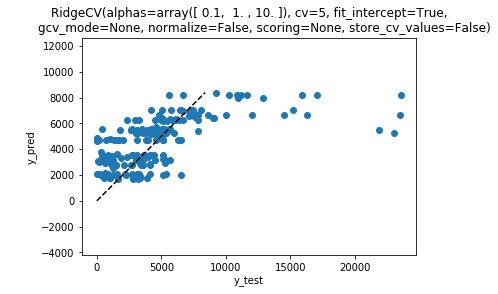

Average confidence score for categorical X with Ridge regression and 5-fold cross validation: 0.3550699785272473
MSE: Census Tract
48453001100    5.418618e+06
dtype: float64
MAPE: Census Tract
48453001100    14.071466
dtype: float64


year_2018    year_2019  day of year_1  day of year_2  \
Census Tract                                                           
48453001100  -1741.429764  1741.429764            0.0            0.0   

              day of year_3  day of year_4  day of year_5  day of year_6  \
Census Tract                                                               
48453001100             0.0    -228.246322    -222.685396            0.0   

              day of year_7  day of year_8  ...  day of year_364  \
Census Tract                                ...                    
48453001100     -196.932491            0.0  ...      -103.110558   

              day of year_365  day of week_0  day of week_1  day of week_2  \
Census Tract                                                                 
48453001100               0.0     -840.35986   -1107.056429    -776.533857   

              day of week_3  day of week_4  day of week_5  day of week_6  \
Census Tract                                                               
48453001100      -76.522621     299.092274    1822.922092     678.458402   

              hour_0  
Census Tract          
48453001100      0.0  

[1 rows x 375 columns]

In [79]:
X, y = make_xy(1, sample_rate='D')

ohe = OneHotEncoder(categories='auto')

# fit transform the ohe to create a categorical X
X_vectorized = ohe.fit_transform(X).toarray()

    # Split into test and training data
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.4, random_state=42)

    # Fit classifier to training data
reg = RidgeCV(cv=5)
reg.fit(X_train, y_train)

    # Predict on test data
y_pred = reg.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.plot([0, max(y_pred)], [0, max(y_pred)], '--k')
plt.title(str(reg))
plt.axis('equal')
plt.show()
plt.close()

print(f'Average confidence score for categorical X with Ridge regression and 5-fold cross validation: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAPE: {mape_error(y_test, y_pred)}')
    
pd.DataFrame(reg.coef_, columns=ohe.get_feature_names(['year', 'day of year', 'day of week', 'hour']), index=y.columns)

The r2 score for ridge regression was very similar to the results of the linear regression.  Both were about 0.62.  Try improving by tuning the alpha hyperparameter

### Hyperparameter Tuning with grid search

In [80]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge # Use 'plain' ridge because CV will be completed by gridsearchcv
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Lasso

# Make a list of alpha values to try
params_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

#Ridge
ridge = Ridge()
ridge_tune = GridSearchCV(ridge, params_ridge, cv=5)
ridge_tune.fit(X_train, y_train)
y_pred_tune = ridge_tune.predict(X_test)
print(ridge_tune.best_estimator_)
print(ridge_tune.best_params_)
print(ridge_tune.best_score_)
print(f'R2 prediction score {r2_score(y_test, y_pred_tune)}')
print(f'MAPE: {mape_error(y_test, y_pred_tune)}')


# improve the ridge estimator.  Since 1 was the best alpha, try some more values near one
params_ridge_2 = {'alpha': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 5]}
ridge_tune_2 = GridSearchCV(ridge, params_ridge_2, cv=5)
ridge_tune_2.fit(X_train, y_train)
y_pred_tune_2 = ridge_tune_2.predict(X_test)
print(ridge_tune_2.best_estimator_)
print(ridge_tune_2.best_params_)
print(ridge_tune_2.best_score_)
print(f'R2 prediction score {r2_score(y_test, y_pred_tune_2)}')
print(f'MAPE: {mape_error(y_test, y_pred_tune_2)}')

# Try grid searching on linear regression
params_linreg = {'fit_intercept': [True, False], 'normalize': [True, False]}
linreg_tune = GridSearchCV(linreg, params_linreg, cv=5)
linreg_tune.fit(X_train, y_train)
y_pred_linreg_tune = linreg_tune.predict(X_test)
print(linreg_tune.best_estimator_)
print(linreg_tune.best_score_)
print(f'linreg_tune R2 prediction score {r2_score(y_test, y_pred_linreg_tune)}')
print(f'MAPE: {mape_error(y_test, y_pred_linreg_tune)}')

# # Try grid searching on a bayesian ridge regression
# params_b_ridge = {
#     'alpha_1': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
#     'alpha_2': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
#     'lambda_1': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
#     'lambda_2': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
# }
# b_ridge = BayesianRidge()
# b_ridge_tune = GridSearchCV(b_ridge, params_b_ridge, cv=5)
# b_ridge_tune.fit(X_train, y_train)
# y_pred_b_ridge_tune = b_ridge_tune.predict(X_test)
# print(b_ridge_tune.best_estimator_)
# print(b_ridge_tune.best_score_)
# print(f'Bayesian Ridge R2 score: {r2_score(y_test, y_pred_b_ridge_tune)}')

# Try a Lasso Regression --actually don't, it does not converge.
# lasso = Lasso() #max_iter=10000 did not converge
# lasso_tune = GridSearchCV(lasso, params_ridge, cv=5) # start with the ridge params
# lasso_tune.fit(X_train, y_train)
# y_pred_tune_lasso = lasso_tune.predict(X_test)
# print(lasso_tune.best_estimator_)
# print(lasso_tune.best_score_)
# print(r2_score(y_test, y_pred_tune_lasso))


/Users/trevor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
{'alpha': 10}
0.3783562476967938
R2 prediction score 0.3550699785272473
MAPE: Census Tract
48453001100    14.071466
dtype: float64
Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)
{'alpha': 5}
0.37917959879596386
R2 prediction score 0.35625635745880246
MAPE: Census Tract
48453001100    13.416749
dtype: float64
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)
-2.0347053917787786e+25
linreg_tune R2 prediction score -3.2717663390982426e+25
MAPE: Census Tract
48453001100    2.727078e+12
dtype: float64


/Users/trevor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



In [81]:
# get dates out of X train to plot
X_test_dates = pd.DataFrame(ohe.inverse_transform(X_test), columns=['year', 'day of year', 'day of week', 'hour'])

X_test_dates['month'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%m')
X_test_dates['day'] = pd.to_datetime(X_test_dates['day of year'], format='%j').dt.strftime('%d')
X_test_dates = pd.to_datetime(X_test_dates[['year', 'month', 'day', 'hour']])

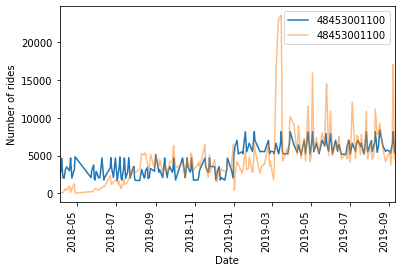

In [82]:
# Create a DataFrame of predictions
predictions_df = pd.DataFrame(y_pred, columns=y.columns, index=X_test_dates)

# Plot date vs number of rides predicted and actual rides
for i, ct in enumerate(predictions_df.columns):
    predictions_df.plot(y=ct)
    y_test[ct].plot(alpha=0.5)
    plt.xticks(rotation=90)
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Number of rides')
    plt.show()

## Batch Gradient Descent

### Define Batch Gradient Descent Functions

In [83]:
def mean_squared_error(truth, predicted):
    m = truth.shape[0]
    mse = (np.sum((predicted - truth) ** 2)) / (2 * m)
    return mse

def batch_gradient_descent(X, y, learn_rate, n_iter):
    
    weights = np.zeros(X.shape[1])
    
    history = []
    m = len(y)
    
    predict = lambda x: np.dot(x, weights)
    derivative = lambda loss: (X.T.dot(loss)) / m
    
    for i in range(n_iter):
        hypothesis = predict(X)
        loss = hypothesis - y
        weights = weights - learn_rate * derivative(loss)
        
        
        if i % 50 == 0:
            history.append(mean_squared_error(X.dot(weights), y))
    
    return predict, history

### Create data set and predictions

In [84]:
# Make Xy for the top census tract
X, y = make_xy(1, sample_rate='D')

# One Hot encode X
ohe = OneHotEncoder(categories='auto') 
X_vectorized = ohe.fit_transform(X).toarray()

# convert y to series by extracting census tract data
y = y.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.4)

In [85]:
# Run the predictor
predictor, history = batch_gradient_descent(X_train, y_train, 0.05, 50000)

learning rate: 0.05, n_iterations: 50,000, mean squared error: 4931763.59991488
r squared score: 0.2562104484216393
MAPE: 1.9489987709573309


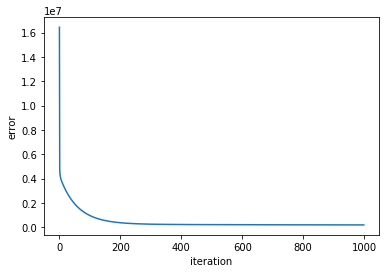

In [86]:
# Evaluate the predictor
y_pred = predictor(X_test)
print(f'learning rate: 0.05, n_iterations: 50,000, mean squared error: {mean_squared_error(y_test, y_pred)}')
print(f'r squared score: {r2_score(y_test, y_pred)}')
print(f'MAPE: {mape_error(y_test, y_pred)}')

plt.plot(history)
plt.xlabel('iteration')
plt.ylabel('error')
plt.show()

This r2 score is slightly lower than the ridge regression, but it may be able to be improved by hyperparameter tuning.

### Tune Hyperparameters

In [87]:
# define a function to test hyperparameters to find best convergence of the model:
import time

def test(X, y, lrates, niterations):
    record = []
    
    for niter in niterations:
        for lrate in lrates:
            start = time.time()
            weights, records = batch_gradient_descent(X, y, lrate, niter)
            delta = time.time() - start
            record.append(dict(lrate=lrate, niter=niter, w=weights, history=records, time=delta))
    
    return record



In [88]:
# Define hyperparameter values to try
learn_rates = [10, 1, 0.5, 0.1, 0.01, 0.001, 0.0001]
n_iterations = [10000, 20000, 50000]

# Test these values
records = test(X_train, y_train, learn_rates, n_iterations)

/Users/trevor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in subtract



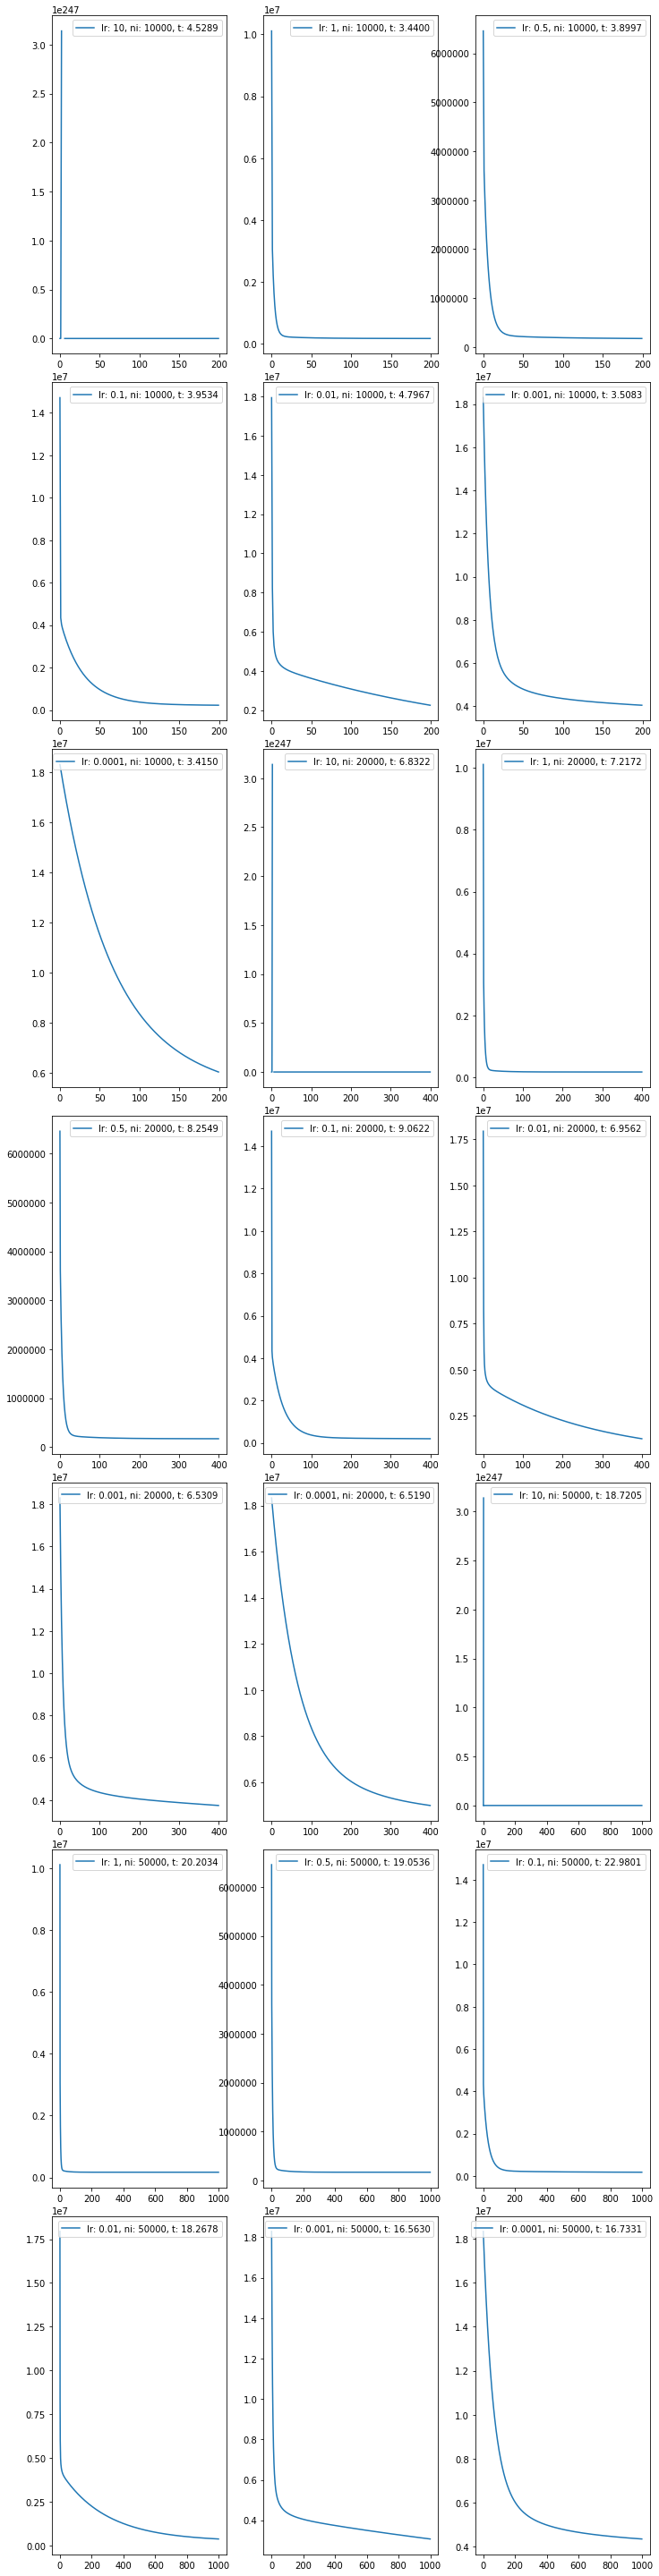

In [89]:
# Plot results
figure, plots = plt.subplots(len(learn_rates), len(n_iterations), figsize=(10,40))
figure.tight_layout()
plots = plots.flatten()
for i, record in enumerate(records):
    time = "{0:.4f}".format(record['time'])
    label = 'lr: {0}, ni: {1}, t: {2}'.format(record["lrate"], record["niter"], time)
    plots[i].plot(record['history'], label=label)
    plots[i].legend(loc='upper right')


In [90]:
import tabulate
time_sorted_records = sorted(records, key=lambda k: k['time']) 
tab_data = time_sorted_records.copy()
for r in tab_data:
    r['cost'] = r['history'][-1]
    del r['history']
    del r['w']
print(tabulate.tabulate(tab_data, headers={'lrate': 'lrate', 'niter': 'niter', 'time': 'elapsed time', 'cost': 'cost'}))

  lrate    niter    elapsed time              cost
-------  -------  --------------  ----------------
 0.0001    10000         3.41501       6.04522e+06
 1         10000         3.44002  170163
 0.001     10000         3.50828       4.04754e+06
 0.5       10000         3.89969  175819
 0.1       10000         3.9534   224550
10         10000         4.52887       0
 0.01      10000         4.79672       2.24924e+06
 0.0001    20000         6.51895       4.99121e+06
 0.001     20000         6.53094       3.74146e+06
10         20000         6.83217       0
 0.01      20000         6.95625       1.25552e+06
 1         20000         7.21716  169697
 0.5       20000         8.25494  170157
 0.1       20000         9.0622   198577
 0.001     50000        16.563         3.07361e+06
 0.0001    50000        16.7331        4.35557e+06
 0.01      50000        18.2678   371011
10         50000        18.7205        0
 0.5       50000        19.0536   169694
 1         50000        20.2034   16969

The model converges fastests at 20,000 iterations with a learning rate of 1. So we'll use these parameters to run the model one more time.

In [93]:
predictor_tuned, history_tuned = batch_gradient_descent(X_train, y_train, 1, 20000)

### Best result with Batch Gradient Descent:

learning rate: 1, n_iterations: 10,000, mean squared error: 5358177.0389733175
r squared score: 0.19190041932175794
MAPE: 1.873254762332974


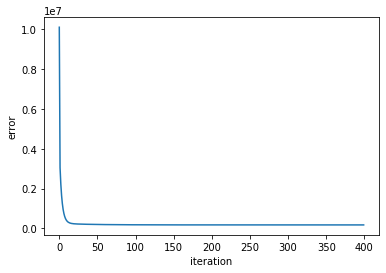

In [94]:
# Evaluate the predictor
y_pred_tuned = predictor_tuned(X_test)
print(f'learning rate: 1, n_iterations: 10,000, mean squared error: {mean_squared_error(y_test, y_pred_tuned)}')
print(f'r squared score: {r2_score(y_test, y_pred_tuned)}')
print(f'MAPE: {mape_error(y_test, y_pred_tuned)}')

plt.plot(history_tuned)
plt.xlabel('iteration')
plt.ylabel('error')
plt.show()

Cite:
http://pavelbazin.com/post/linear-regression-hyperparameters/

@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}

Taylor SJ, Letham B. 2017. Forecasting at scale. PeerJ Preprints 5:e3190v2 https://doi.org/10.7287/peerj.preprints.3190v2

## Using Facebook Prophet

In [101]:
def prophesy(census_tract, df=scooters, sample_rate='H', forecast_periods=30, add_holidays=False, plot=True, plot_components=True, cross_validate=True):
    '''Use Facebook prophet on the specified census tract:
    df: source DataFrame
    census_tract:  string of census tract number
    sample_rate: rate at which to run the sample, defaults to "H" for hourly, can also be "D" for daily
    forecast_periods: number of periods to forecast after primary data
    add_holiday: default to false, can be dataframe that follows fbprophet holiday dataframe conventions
    plot: if True, plot the results
    plot_components: if True, plot the components'''
    
        #Plot the location of the census tract
    fig, (ax2) = plt.subplots()
    map_df.plot(color='0.9', edgecolor='0.0', ax=ax2)
    ax2.axis('off')
    ax2.set(title='Location of ' + census_tract)
    map_df[map_df['CTIDFP00'] == census_tract].plot(color='g', ax=ax2)
    bbox = (-97.919881, -97.589348, 30.139918,30.426626)
    plt.xlim(bbox[0], bbox[1])
    plt.ylim(bbox[2], bbox[3])
    plt.show()
    
    
    # Use ct by hour function to get hourly data for a census tract
    ct_x_by_hour = ct_by_hour(df,census_tract, sample=sample_rate)['n'].reset_index()
    ct_x_by_hour.columns = ['ds', 'y']

    # import facebook prophet
    from fbprophet import Prophet

    # Create a holidays dataframe that includes non-standard holidays (i.e. SXSW)
    sxsw = pd.DataFrame({
        'holiday': 'sxsw',
        'ds': pd.to_datetime(['2017-03-10', '2018-03-09', '2019-03-08']),
        'lower_window': 0,
        'upper_window': 9
    })
    
    if add_holidays is False:
        holidays= sxsw
    else:
        holidays = sxsw.concat(add_holidays)


    # instatiate prophet model, use mult seasonality because the magnitude of peaks/valleys increases
    fbp = Prophet(holidays=holidays, yearly_seasonality=True, seasonality_mode='multiplicative')

    # add standard US holidays
    fbp.add_country_holidays(country_name='US')

    # fit to dataframe
    fbp.fit(ct_x_by_hour)
    
    # create a dataframe for predicting
    future = fbp.make_future_dataframe(periods=forecast_periods, freq=sample_rate)

    # create a forecast
    forecast = fbp.predict(future)

    from fbprophet.plot import add_changepoints_to_plot

    # Plot the results and the components
    if plot is True:
        fig1 = fbp.plot(forecast)
        a = add_changepoints_to_plot(fig1.gca(), fbp, forecast)
    
    if plot_components is True:
        fig2 = fbp.plot_components(forecast)
        
    if cross_validate is True:
        
        # Run cross validation
        from fbprophet.diagnostics import cross_validation, performance_metrics
        from fbprophet.plot import plot_cross_validation_metric
        
        df_cv = cross_validation(fbp, initial='500 days', horizon='7 days')
        performance = performance_metrics(df_cv)
        
        # plot
        fig3 = plot_cross_validation_metric(df_cv, metric='mape')
        
        print(f'{census_tract} r2 score: {r2_score(df_cv.y, df_cv.yhat)}')
        print(f'MAPE: {mape_error(df_cv.y, df_cv.yhat)}')
        return fbp, performance, df_cv, forecast
    else:
        return fbp, forecast

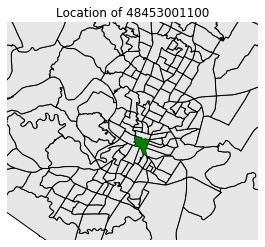

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-08-17 12:00:00 and 2019-09-04 00:00:00


48453001100 r2 score: 0.2890065970561313
MAPE: 0.24695206019865865


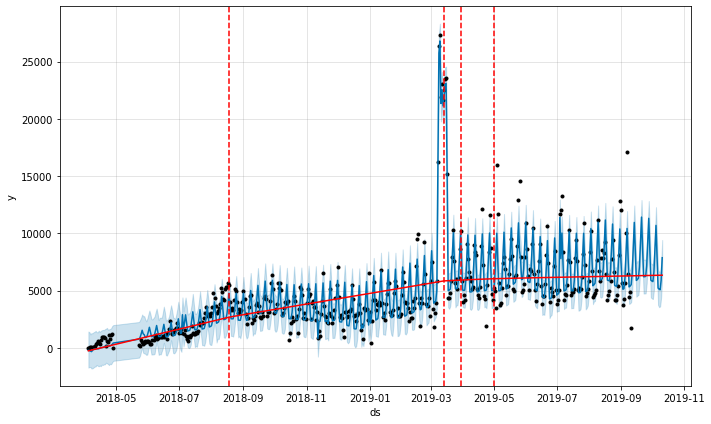

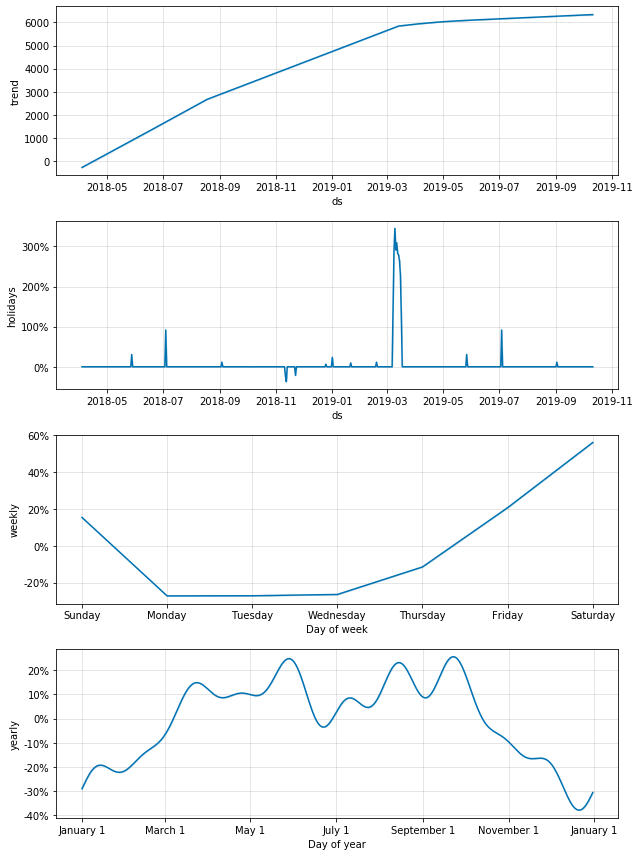

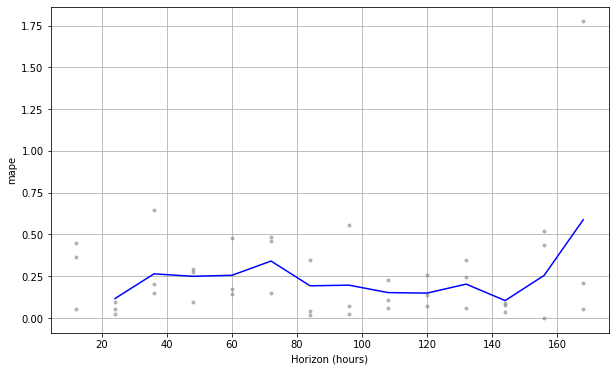

In [115]:
fbp_1100, performance_1100, df_cv_1100, forecast_1100 = prophesy('48453001100', sample_rate='D')

In [116]:
forecast_1100

ds        trend   yhat_lower    yhat_upper  trend_lower  \
0   2018-04-04  -268.560572 -1735.861280   1415.995369  -268.560572   
1   2018-04-05  -247.087153 -1683.412132   1361.856537  -247.087153   
2   2018-04-06  -225.613734 -1686.490529   1162.266154  -225.613734   
3   2018-04-07  -204.140316 -1817.667774   1284.445202  -204.140316   
4   2018-04-08  -182.666897 -1799.051088   1255.415677  -182.666897   
5   2018-04-09  -161.193479 -1727.526526   1355.448406  -161.193479   
6   2018-04-10  -139.720060 -1651.270379   1390.767611  -139.720060   
7   2018-04-11  -118.246641 -1635.045085   1475.788015  -118.246641   
8   2018-04-12   -96.773223 -1497.408739   1368.072888   -96.773223   
9   2018-04-13   -75.299804 -1572.827403   1341.016164   -75.299804   
10  2018-04-14   -53.826385 -1624.528838   1494.033561   -53.826385   
11  2018-04-15   -32.352967 -1558.733720   1367.808829   -32.352967   
12  2018-04-16   -10.879548 -1613.506296   1479.622259   -10.879548   
13  2018-04-17    10.593871 -1478.438232   1525.161323    10.593871   
14  2018-04-18    32.067289 -1505.525261   1558.619749    32.067289   
15  2018-04-19    53.540708 -1453.650778   1534.021556    53.540708   
16  2018-04-20    75.014127 -1448.056036   1623.096771    75.014127   
17  2018-04-21    96.487546 -1308.048282   1664.104706    96.487546   
18  2018-04-22   117.960965 -1353.720911   1735.925277   117.960965   
19  2018-04-23   139.434385 -1429.724690   1566.984430   139.434385   
20  2018-04-24   160.907804 -1511.551894   1609.369765   160.907804   
21  2018-04-25   182.381223 -1396.763825   1639.102382   182.381223   
22  2018-04-26   203.854643 -1441.831826   1706.494478   203.854643   
23  2018-04-27   225.328062 -1266.882971   1890.755295   225.328062   
24  2018-04-28   246.801481 -1142.668471   1978.420691   246.801481   
25  2018-05-23   783.636965  -863.621543   2249.044979   783.636965   
26  2018-05-24   805.110385  -685.722971   2415.891490   805.110385   
27  2018-05-25   826.583804  -299.614414   2618.180354   826.583804   
28  2018-05-26   848.057223   -31.586228   2907.433552   848.057223   
29  2018-05-27   869.530643  -437.432089   2745.847793   869.530643   
..         ...          ...          ...           ...          ...   
502 2019-09-12  6284.953561  4977.710359   8062.565490  6284.953561   
503 2019-09-13  6286.767576  7059.166274  10141.987256  6286.767576   
504 2019-09-14  6288.581592  9419.753816  12428.724569  6288.581592   
505 2019-09-15  6290.395607  6983.176344   9847.935528  6290.395607   
506 2019-09-16  6292.209623  4454.623735   7381.042690  6292.209623   
507 2019-09-17  6294.023639  4554.989340   7574.664031  6293.781812   
508 2019-09-18  6295.837654  4605.656874   7547.606187  6295.246391   
509 2019-09-19  6297.651670  5614.410209   8553.896697  6296.595456   
510 2019-09-20  6299.465686  7640.170857  10576.966605  6297.853249   
511 2019-09-21  6301.279701  9857.846659  12908.106958  6298.962479   
512 2019-09-22  6303.093717  7329.223015  10321.247174  6300.048838   
513 2019-09-23  6304.907732  4736.863794   7655.823462  6301.354770   
514 2019-09-24  6306.721748  4737.647122   7716.716165  6302.371798   
515 2019-09-25  6308.535764  4747.359864   7630.222371  6303.257242   
516 2019-09-26  6310.349779  5623.838710   8720.625874  6303.886714   
517 2019-09-27  6312.163795  7590.491232  10697.460888  6304.906842   
518 2019-09-28  6313.977810  9740.862547  12821.123219  6305.961043   
519 2019-09-29  6315.791826  7139.016929  10236.170184  6306.886796   
520 2019-09-30  6317.605842  4397.527592   7381.463625  6307.502308   
521 2019-10-01  6319.419857  4306.112898   7335.874071  6308.190918   
522 2019-10-02  6321.233873  4252.027511   7212.149533  6308.306071   
523 2019-10-03  6323.047888  5076.408247   8064.564188  6309.034379   
524 2019-10-04  6324.861904  7109.820863  10056.890861  6309.547286   
525 2019-10-05  6326.675920  9105.686008  12282.879297  6309.975504   
526 2019-10-06  6328.489935  6564.64

In [41]:
mape_error(df_cv_1100.y, df_cv_1100.yhat)

0.24695206019865865

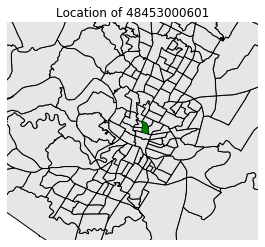

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000601 r2 score: 0.04085007761200343
MAPE: 0.34282422881404034


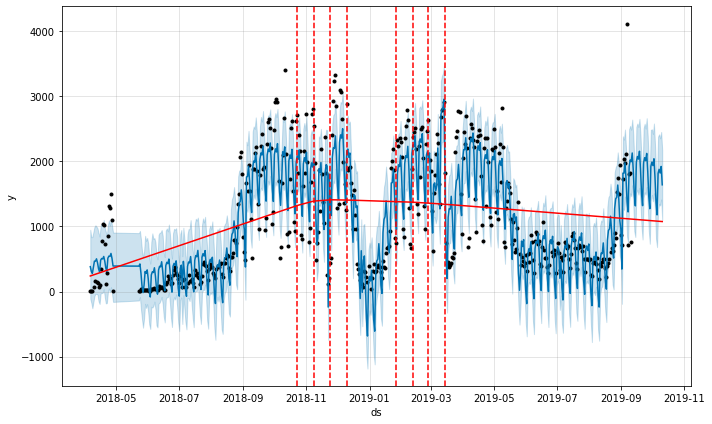

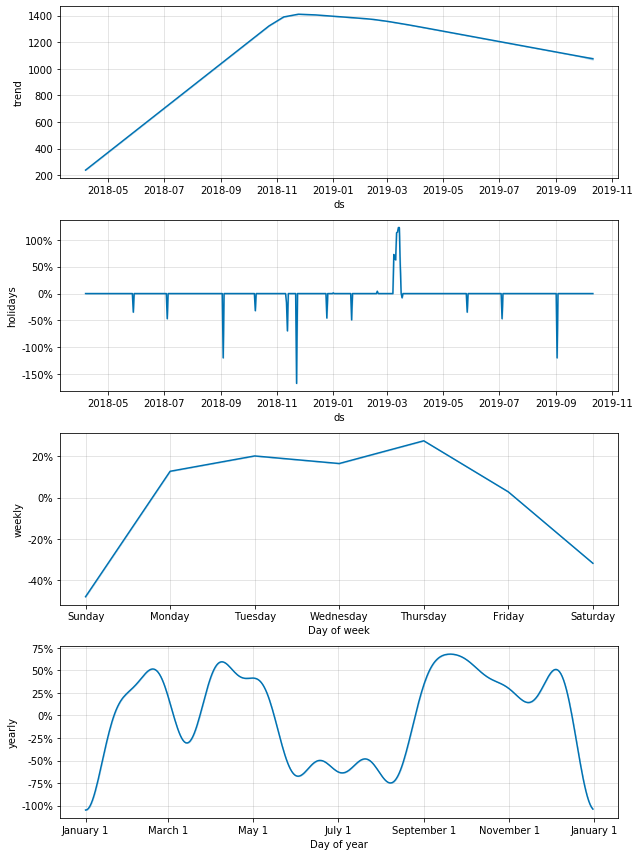

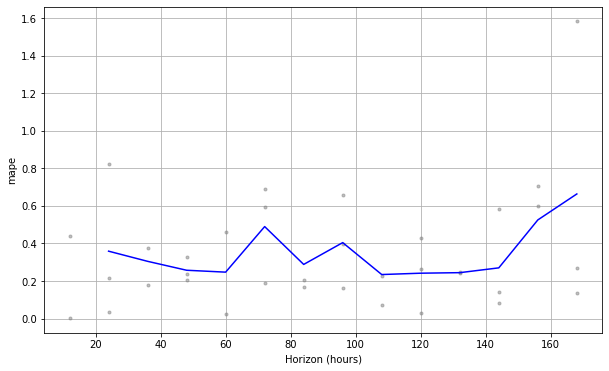

In [42]:
fbp_0601, performance_0601, df_cv_0601 = prophesy('48453000601', sample_rate='D')

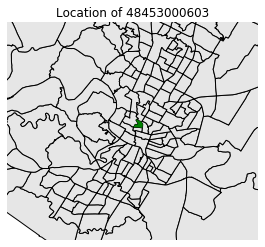

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000603 r2 score: 0.3482429726404709
MAPE: 0.24163398129421929


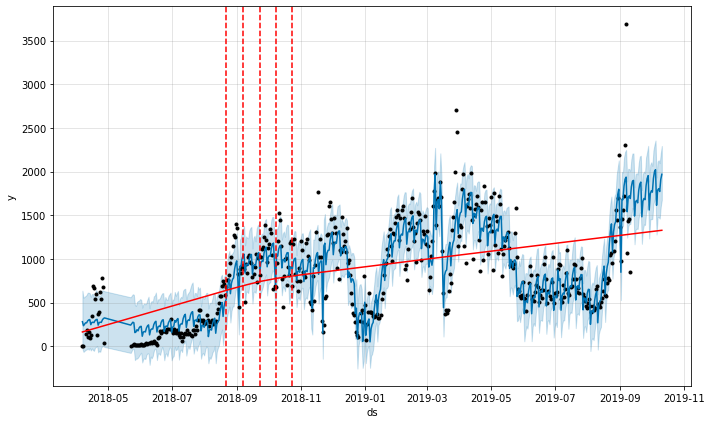

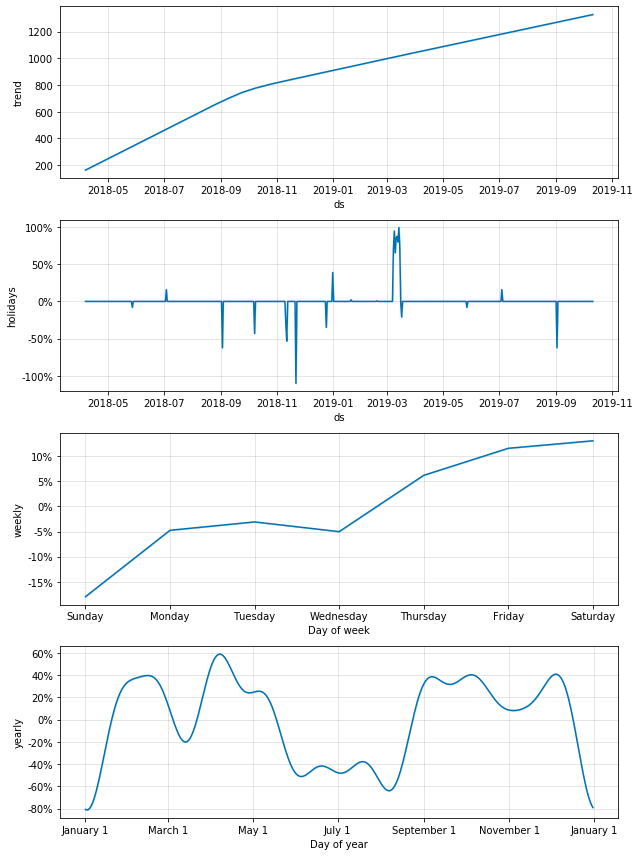

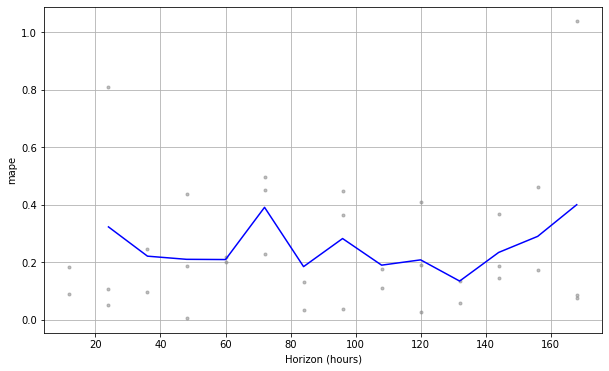

In [43]:
fbp_0603, performance_0603, df_cv_0603 = prophesy('48453000603', sample_rate='D')

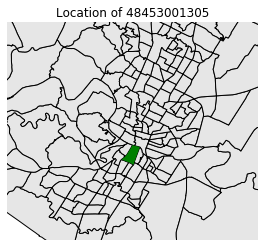

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453001305 r2 score: 0.22968826558733013
MAPE: 0.26220272445999676


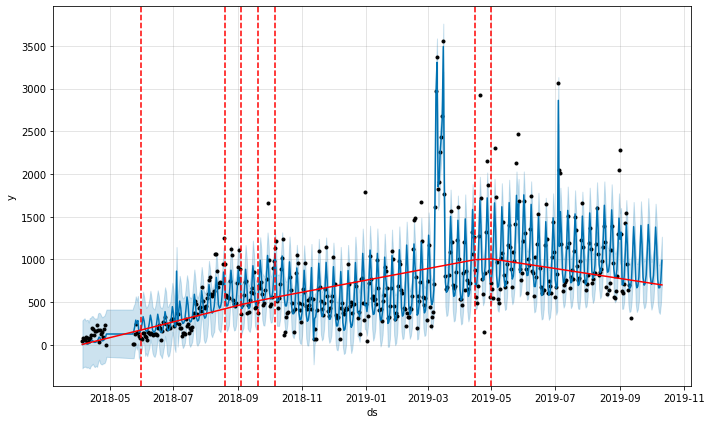

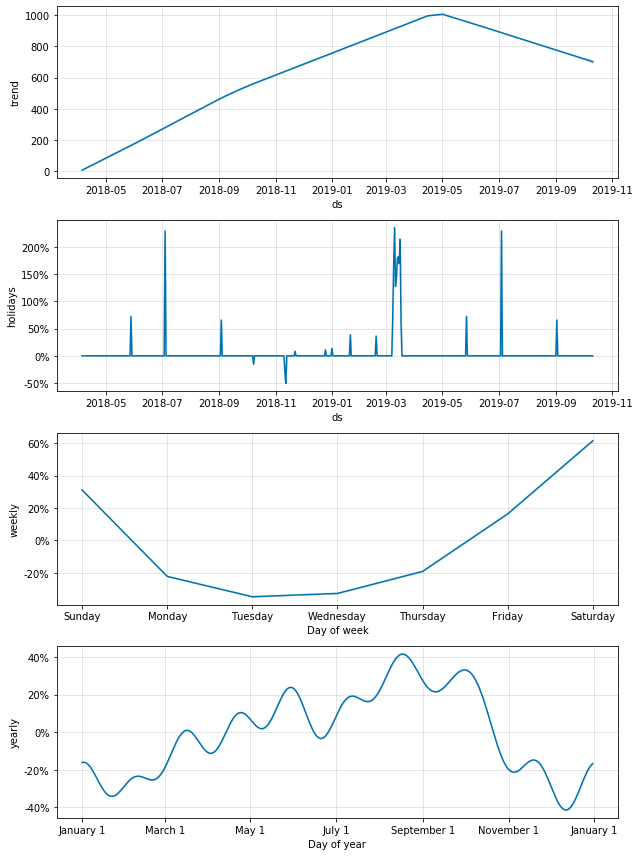

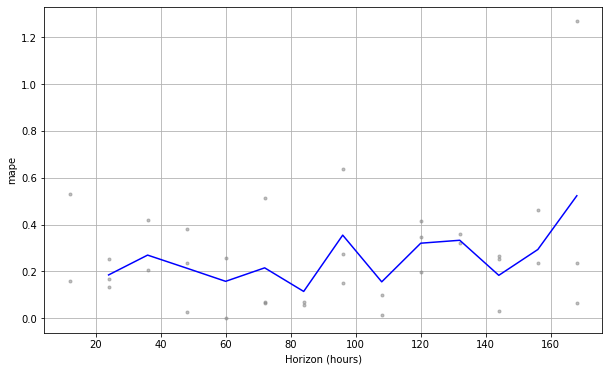

In [44]:
fbp_1305, performance_1305, df_cv_1305 = prophesy('48453001305', sample_rate='D')

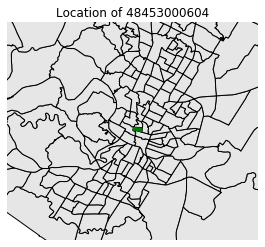

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000604 r2 score: 0.3262133004839838
MAPE: 0.23890914113506773


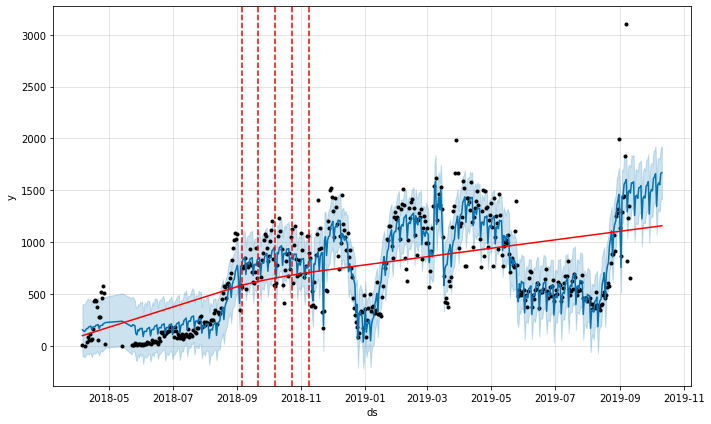

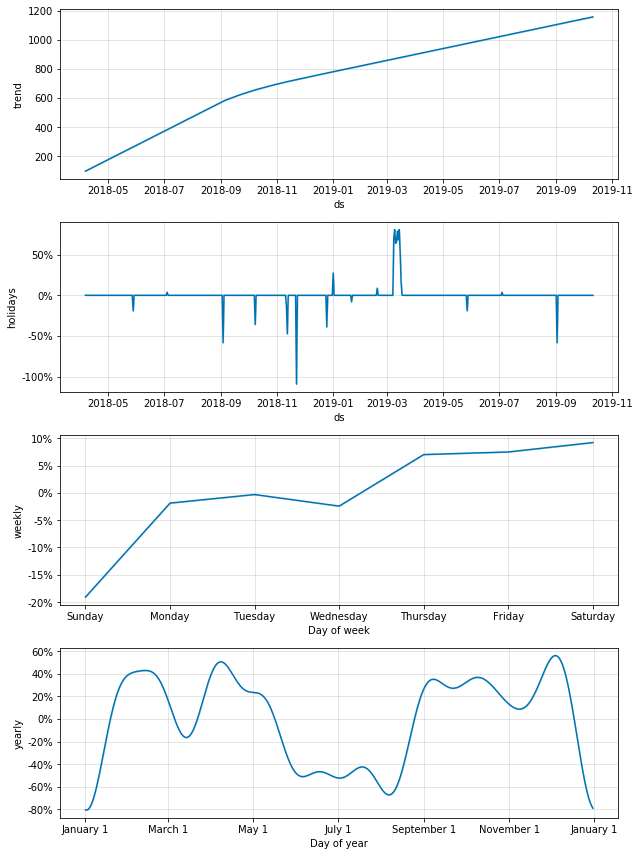

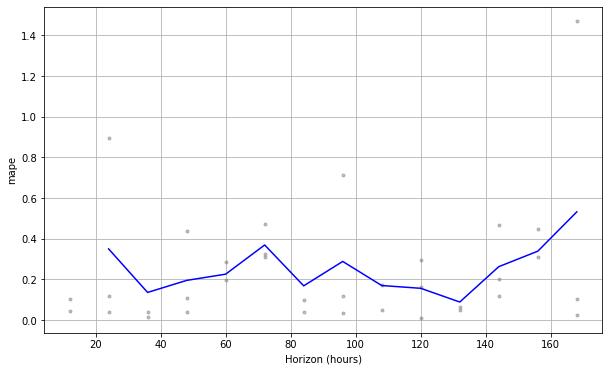

In [45]:
fbp_0604, performance_0604, df_cv_0604 = prophesy('48453000604', sample_rate='D')

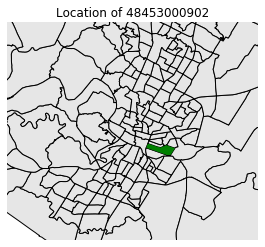

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000902 r2 score: 0.7502091494497275
MAPE: 0.19019803095254437


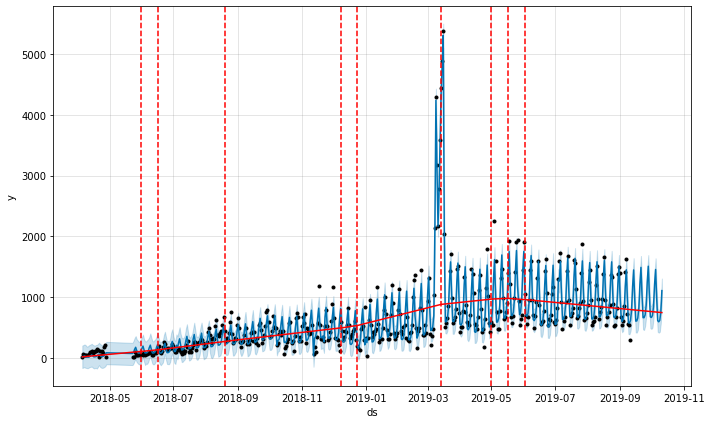

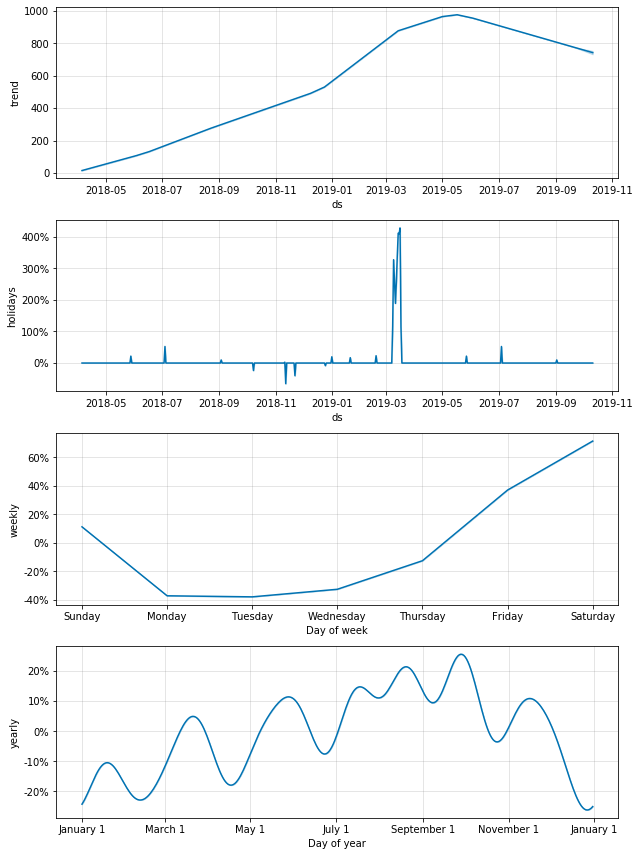

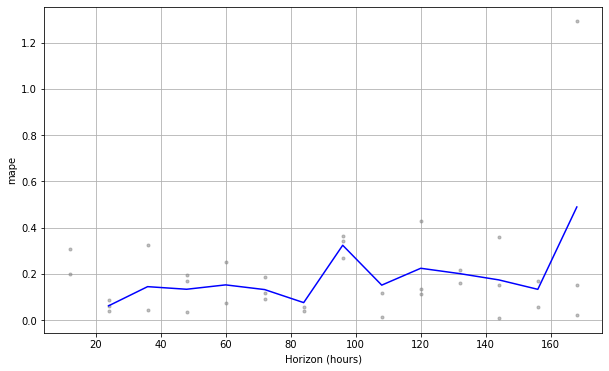

In [46]:
fbp_0902, performance_0902, df_cv_0902 = prophesy('48453000902', sample_rate='D')

In [47]:
r2_score(df_cv_0902['y'], df_cv_0902['yhat'] )

0.7502091494497275

In [48]:
mape_error(df_cv_0902['y'], df_cv_0902['yhat'] \)

0.19019803095254437

In [114]:
fbp_1100

In [111]:
census_starts.head().index.values

array(['48453001100', '48453000601', '48453000603', '48453001305',
       '48453000604'], dtype=object)

In [119]:
forecast_1100

ds        trend   yhat_lower    yhat_upper  trend_lower  \
0   2018-04-04  -268.560572 -1735.861280   1415.995369  -268.560572   
1   2018-04-05  -247.087153 -1683.412132   1361.856537  -247.087153   
2   2018-04-06  -225.613734 -1686.490529   1162.266154  -225.613734   
3   2018-04-07  -204.140316 -1817.667774   1284.445202  -204.140316   
4   2018-04-08  -182.666897 -1799.051088   1255.415677  -182.666897   
5   2018-04-09  -161.193479 -1727.526526   1355.448406  -161.193479   
6   2018-04-10  -139.720060 -1651.270379   1390.767611  -139.720060   
7   2018-04-11  -118.246641 -1635.045085   1475.788015  -118.246641   
8   2018-04-12   -96.773223 -1497.408739   1368.072888   -96.773223   
9   2018-04-13   -75.299804 -1572.827403   1341.016164   -75.299804   
10  2018-04-14   -53.826385 -1624.528838   1494.033561   -53.826385   
11  2018-04-15   -32.352967 -1558.733720   1367.808829   -32.352967   
12  2018-04-16   -10.879548 -1613.506296   1479.622259   -10.879548   
13  2018-04-17    10.593871 -1478.438232   1525.161323    10.593871   
14  2018-04-18    32.067289 -1505.525261   1558.619749    32.067289   
15  2018-04-19    53.540708 -1453.650778   1534.021556    53.540708   
16  2018-04-20    75.014127 -1448.056036   1623.096771    75.014127   
17  2018-04-21    96.487546 -1308.048282   1664.104706    96.487546   
18  2018-04-22   117.960965 -1353.720911   1735.925277   117.960965   
19  2018-04-23   139.434385 -1429.724690   1566.984430   139.434385   
20  2018-04-24   160.907804 -1511.551894   1609.369765   160.907804   
21  2018-04-25   182.381223 -1396.763825   1639.102382   182.381223   
22  2018-04-26   203.854643 -1441.831826   1706.494478   203.854643   
23  2018-04-27   225.328062 -1266.882971   1890.755295   225.328062   
24  2018-04-28   246.801481 -1142.668471   1978.420691   246.801481   
25  2018-05-23   783.636965  -863.621543   2249.044979   783.636965   
26  2018-05-24   805.110385  -685.722971   2415.891490   805.110385   
27  2018-05-25   826.583804  -299.614414   2618.180354   826.583804   
28  2018-05-26   848.057223   -31.586228   2907.433552   848.057223   
29  2018-05-27   869.530643  -437.432089   2745.847793   869.530643   
..         ...          ...          ...           ...          ...   
502 2019-09-12  6284.953561  4977.710359   8062.565490  6284.953561   
503 2019-09-13  6286.767576  7059.166274  10141.987256  6286.767576   
504 2019-09-14  6288.581592  9419.753816  12428.724569  6288.581592   
505 2019-09-15  6290.395607  6983.176344   9847.935528  6290.395607   
506 2019-09-16  6292.209623  4454.623735   7381.042690  6292.209623   
507 2019-09-17  6294.023639  4554.989340   7574.664031  6293.781812   
508 2019-09-18  6295.837654  4605.656874   7547.606187  6295.246391   
509 2019-09-19  6297.651670  5614.410209   8553.896697  6296.595456   
510 2019-09-20  6299.465686  7640.170857  10576.966605  6297.853249   
511 2019-09-21  6301.279701  9857.846659  12908.106958  6298.962479   
512 2019-09-22  6303.093717  7329.223015  10321.247174  6300.048838   
513 2019-09-23  6304.907732  4736.863794   7655.823462  6301.354770   
514 2019-09-24  6306.721748  4737.647122   7716.716165  6302.371798   
515 2019-09-25  6308.535764  4747.359864   7630.222371  6303.257242   
516 2019-09-26  6310.349779  5623.838710   8720.625874  6303.886714   
517 2019-09-27  6312.163795  7590.491232  10697.460888  6304.906842   
518 2019-09-28  6313.977810  9740.862547  12821.123219  6305.961043   
519 2019-09-29  6315.791826  7139.016929  10236.170184  6306.886796   
520 2019-09-30  6317.605842  4397.527592   7381.463625  6307.502308   
521 2019-10-01  6319.419857  4306.112898   7335.874071  6308.190918   
522 2019-10-02  6321.233873  4252.027511   7212.149533  6308.306071   
523 2019-10-03  6323.047888  5076.408247   8064.564188  6309.034379   
524 2019-10-04  6324.861904  7109.820863  10056.890861  6309.547286   
525 2019-10-05  6326.675920  9105.686008  12282.879297  6309.975504   
526 2019-10-06  6328.489935  6564.64

## Business Impact

Because these forecasts are the sum total of all scooter providers, it would be naive for one company to assume that they could place the predicted number of scooters and optimize their utilization.  However, these numbers can be used for a scooter provider to determine where to place what percentage of their fleet.

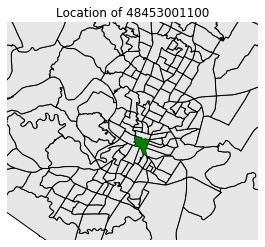

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-08-17 12:00:00 and 2019-09-04 00:00:00


48453001100 r2 score: 0.2890065970561313
MAPE: 0.24695206019865865


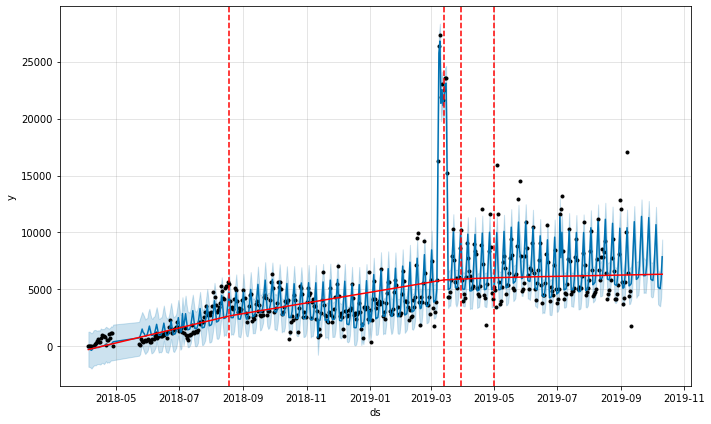

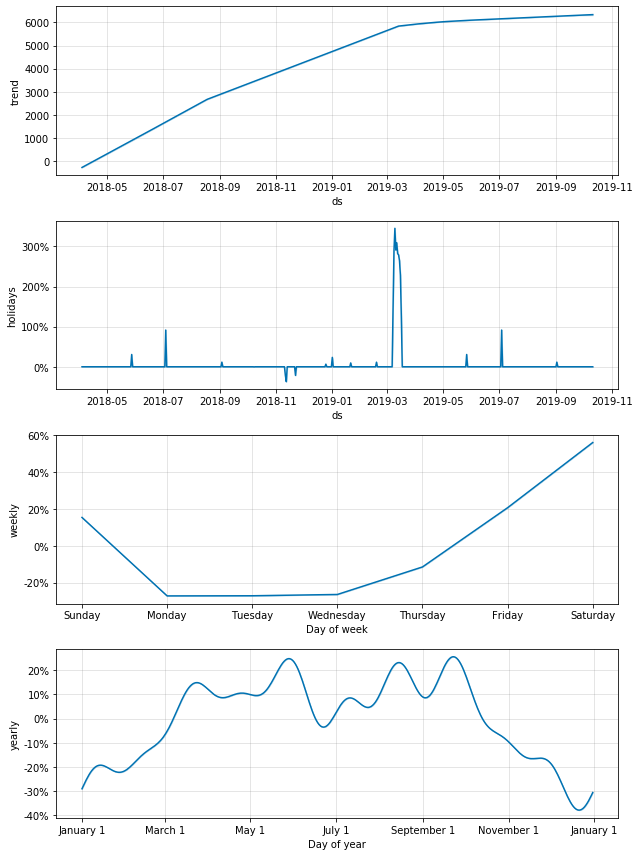

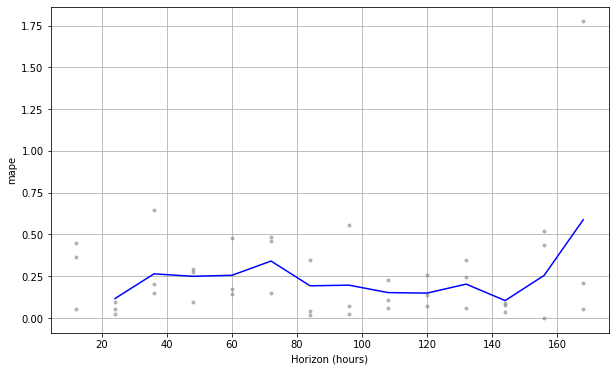

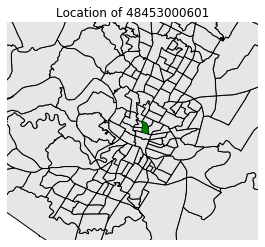

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000601 r2 score: 0.04085007761200343
MAPE: 0.34282422881404034


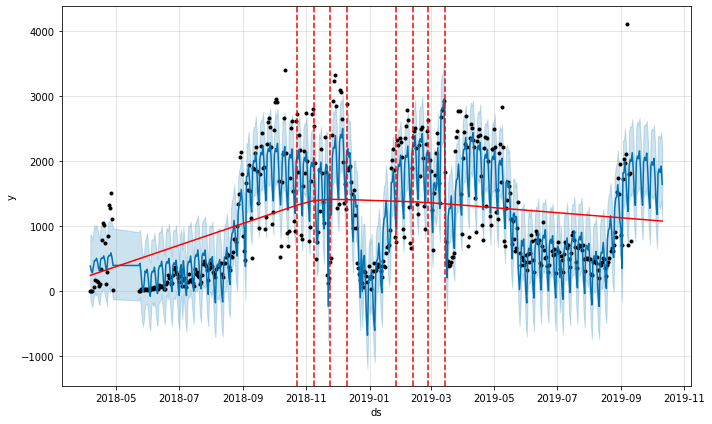

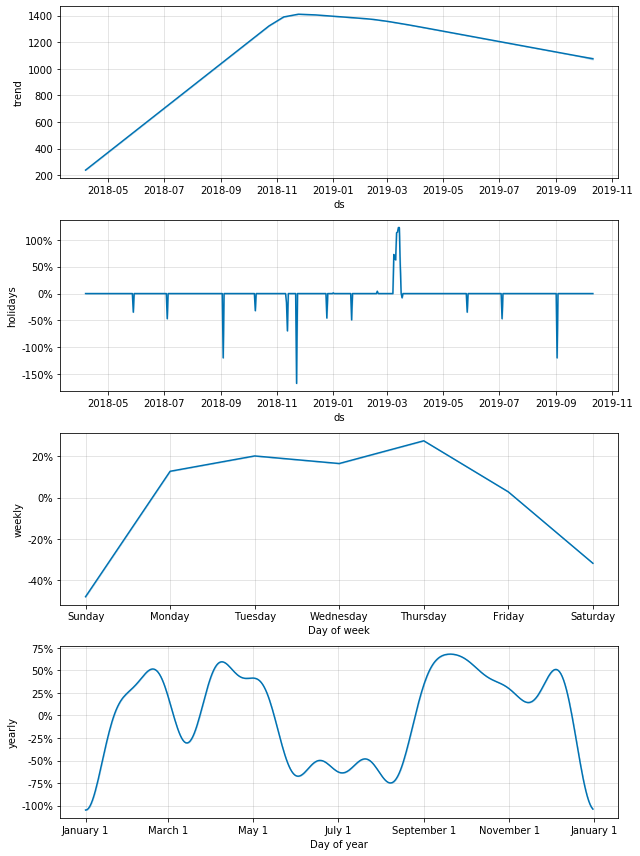

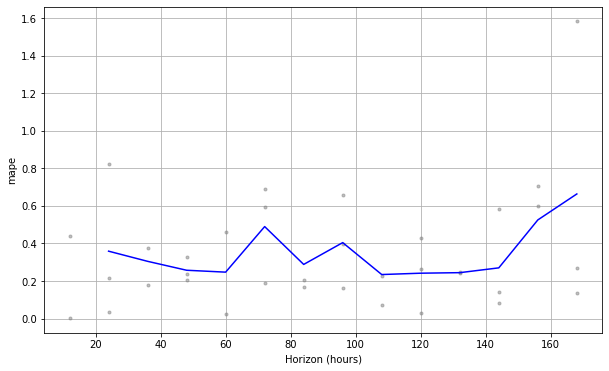

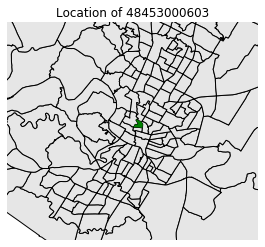

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000603 r2 score: 0.3482429726404709
MAPE: 0.24163398129421929


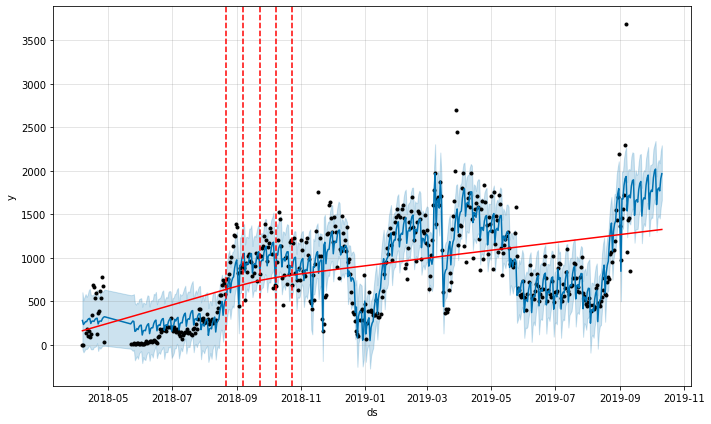

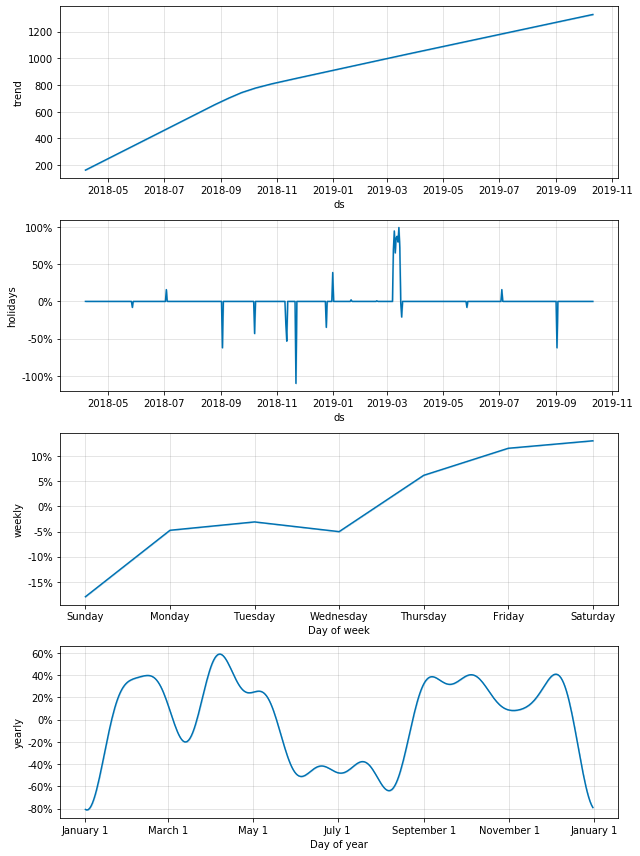

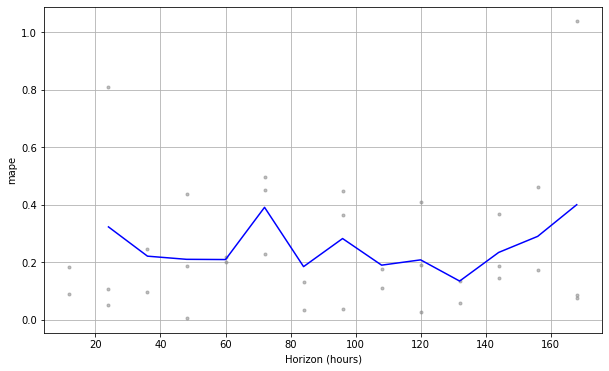

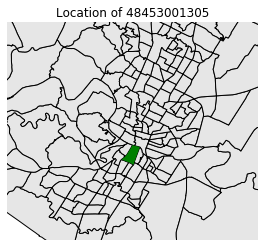

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453001305 r2 score: 0.22968826558733013
MAPE: 0.26220272445999676


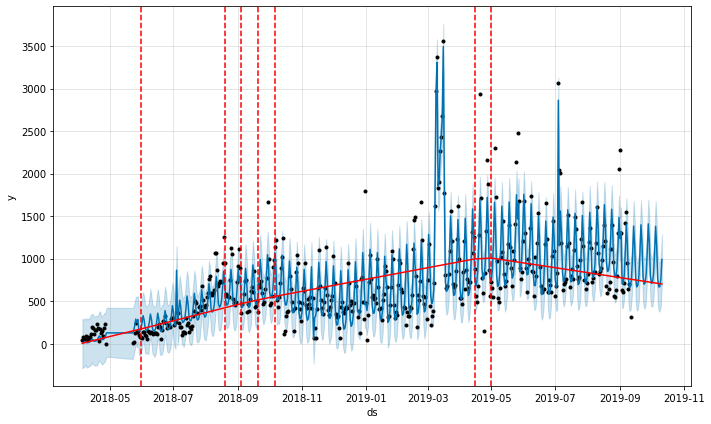

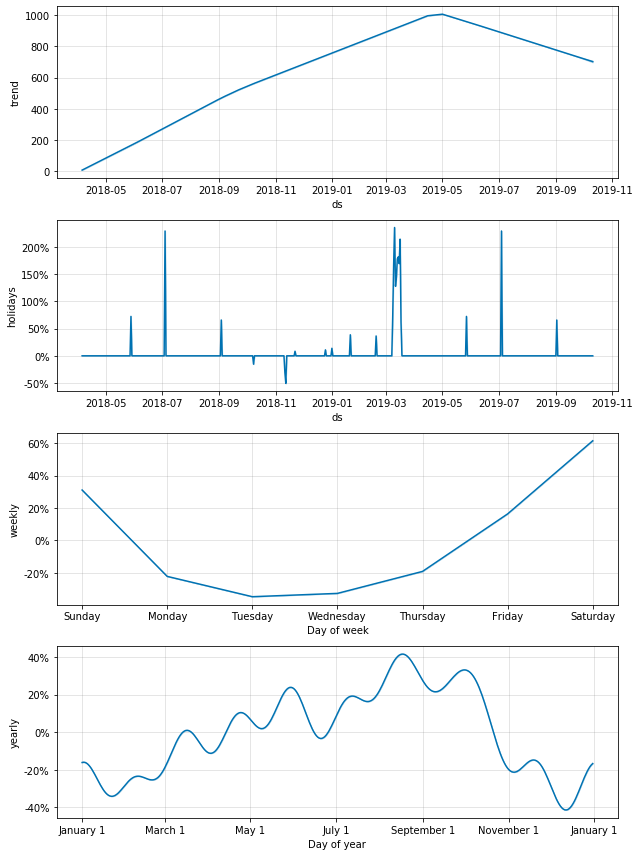

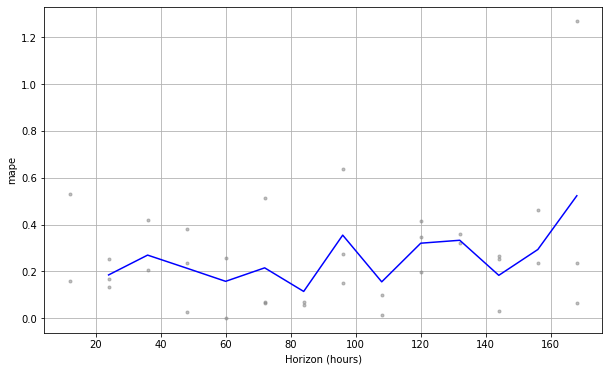

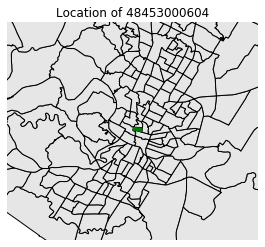

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000604 r2 score: 0.3262133004839838
MAPE: 0.23890914113506773


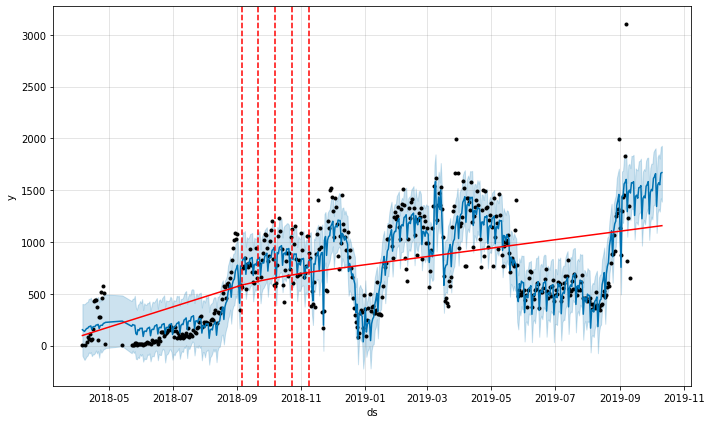

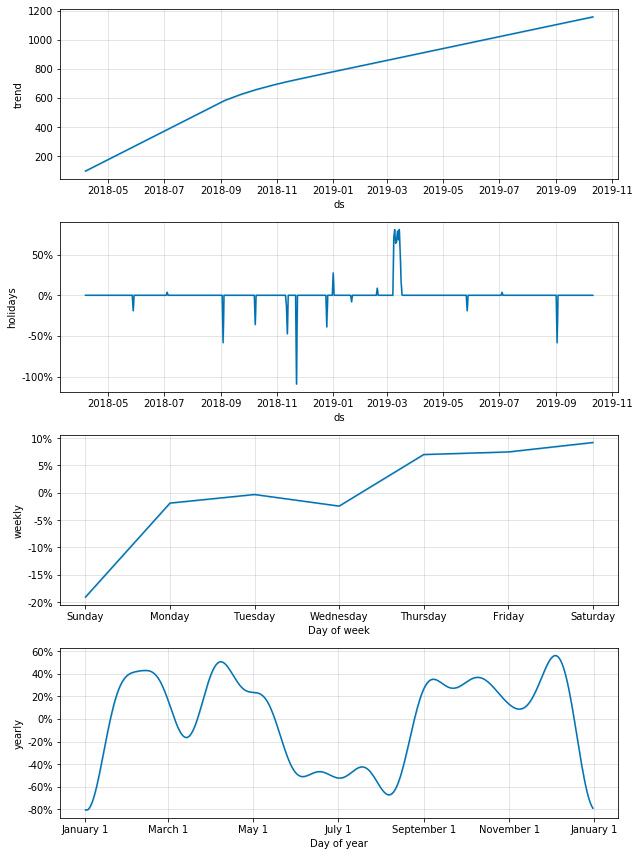

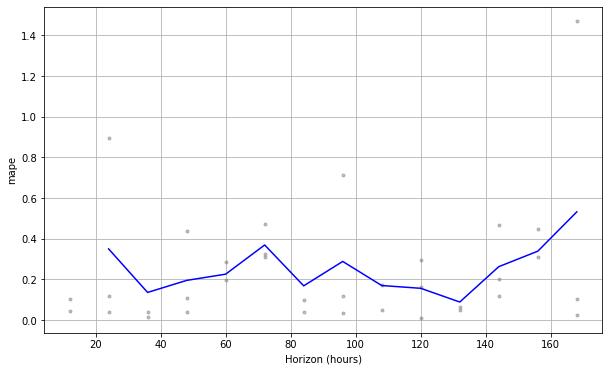

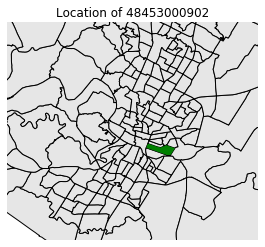

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000902 r2 score: 0.7502091494497275
MAPE: 0.19019803095254437


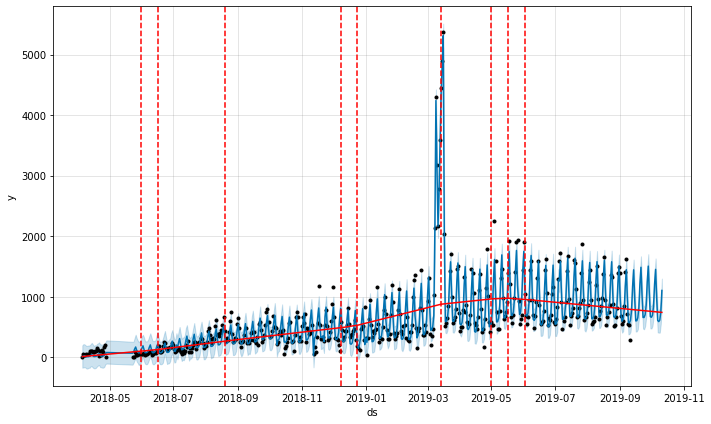

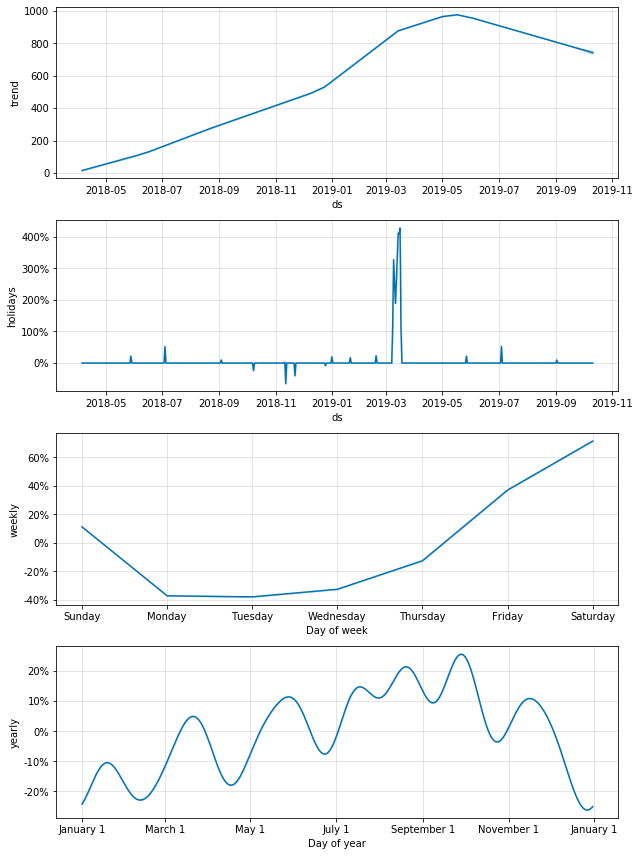

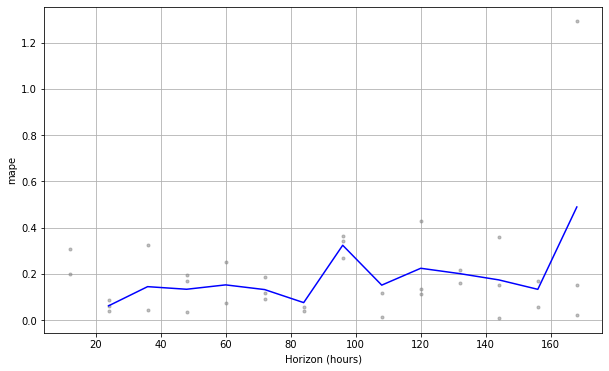

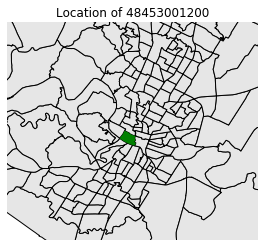

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2019-08-17 12:00:00 and 2019-09-04 00:00:00


48453001200 r2 score: 0.11430676087207081
MAPE: 0.18361393887855046


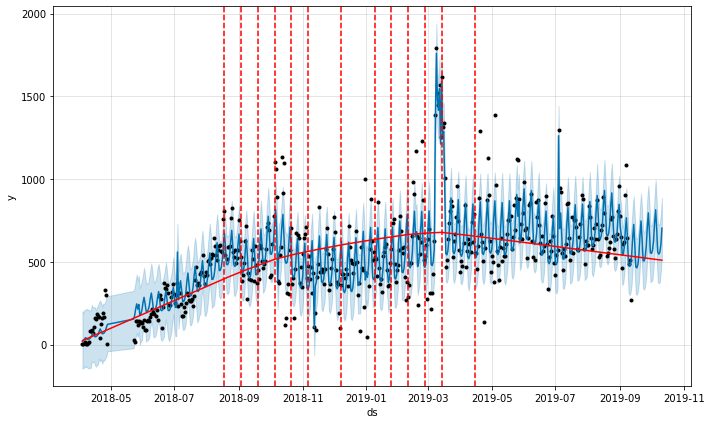

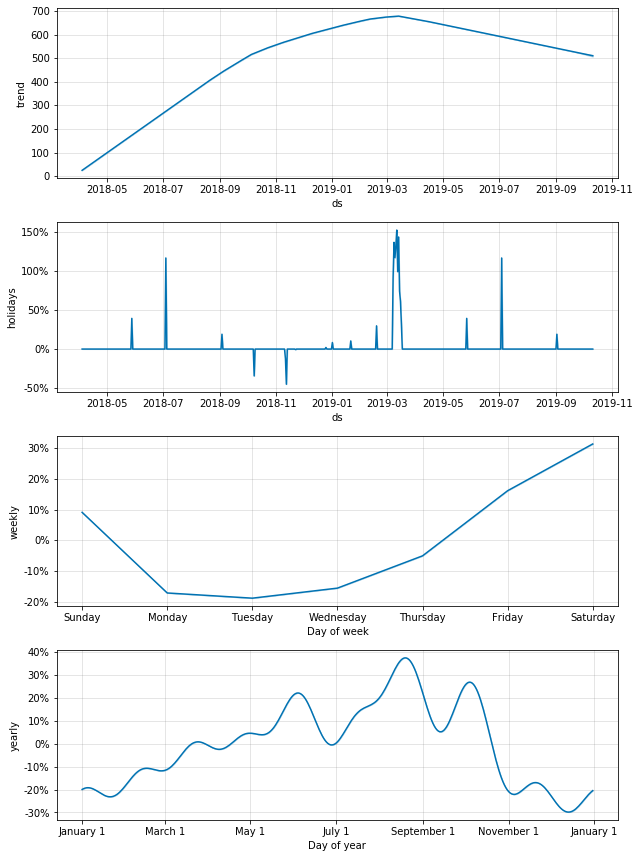

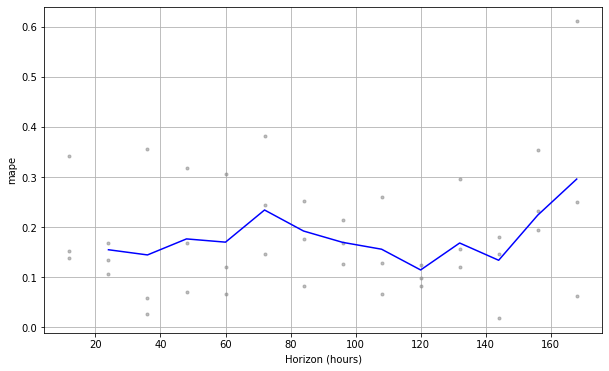

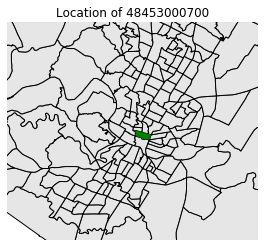

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453000700 r2 score: 0.12907855137853153
MAPE: 0.5292290357394261


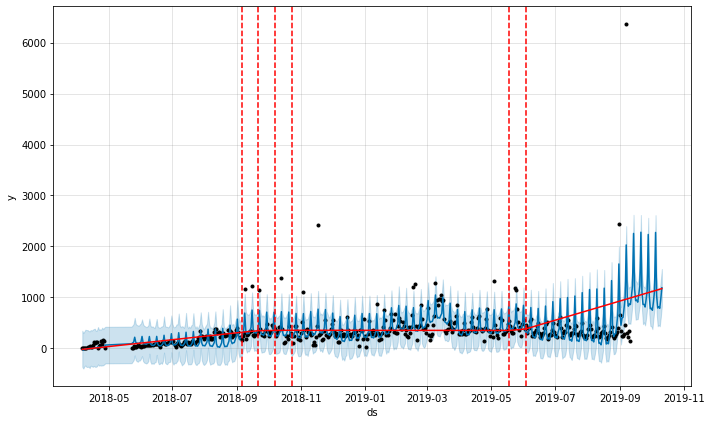

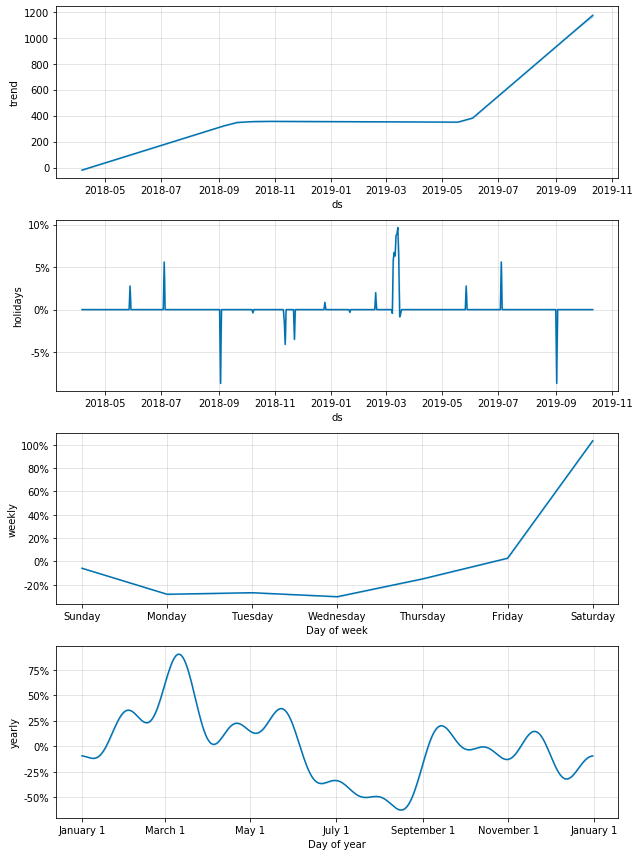

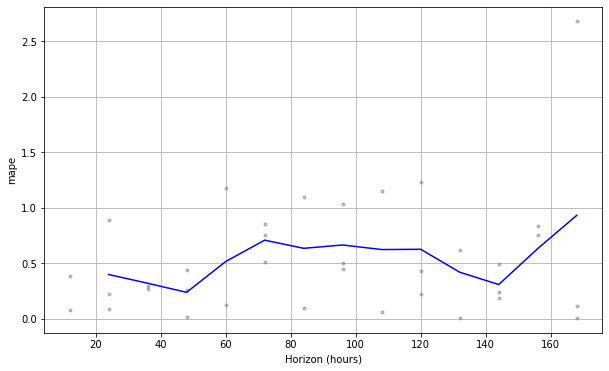

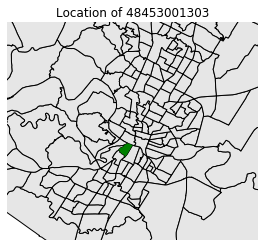

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453001303 r2 score: 0.2891048779620935
MAPE: 0.3559678380041233


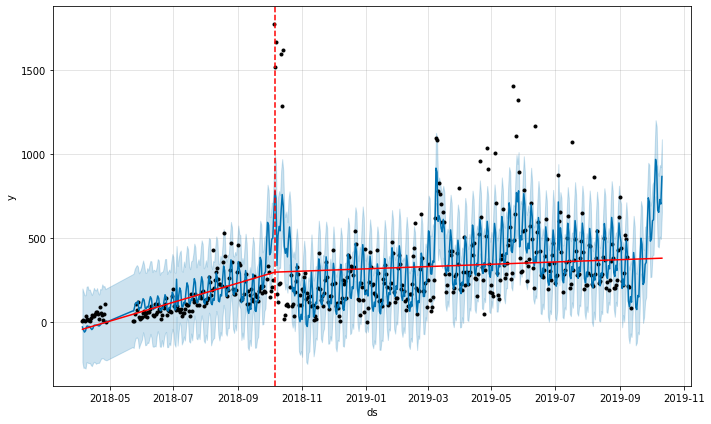

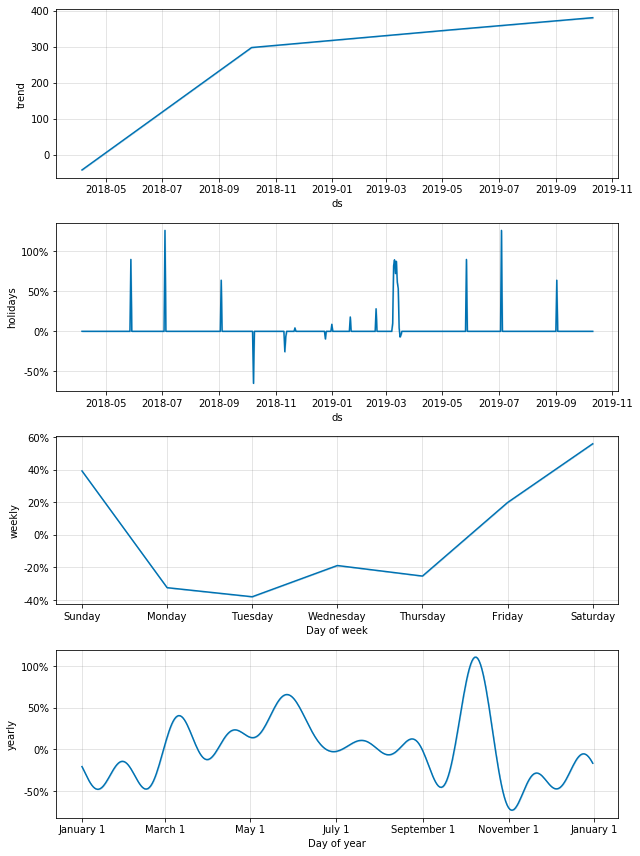

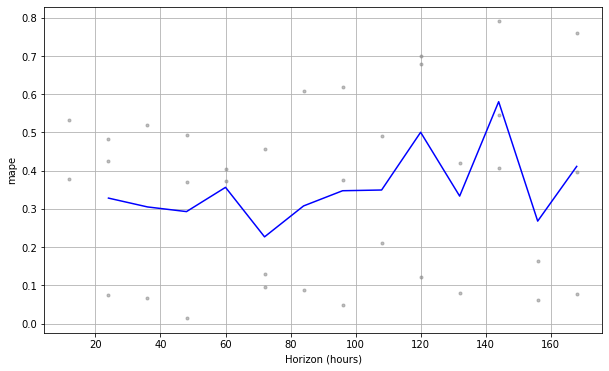

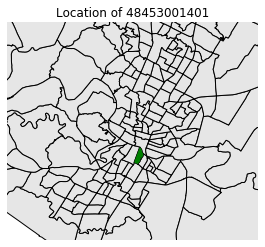

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-08-21 00:00:00 and 2019-09-04 00:00:00


48453001401 r2 score: 0.4323027839432081
MAPE: 0.2709471091478427


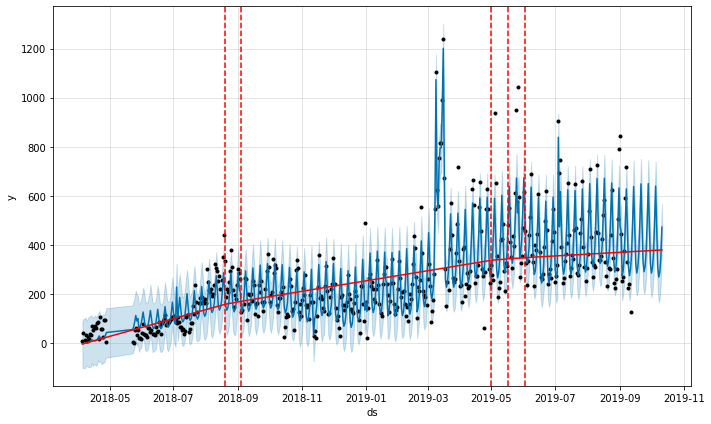

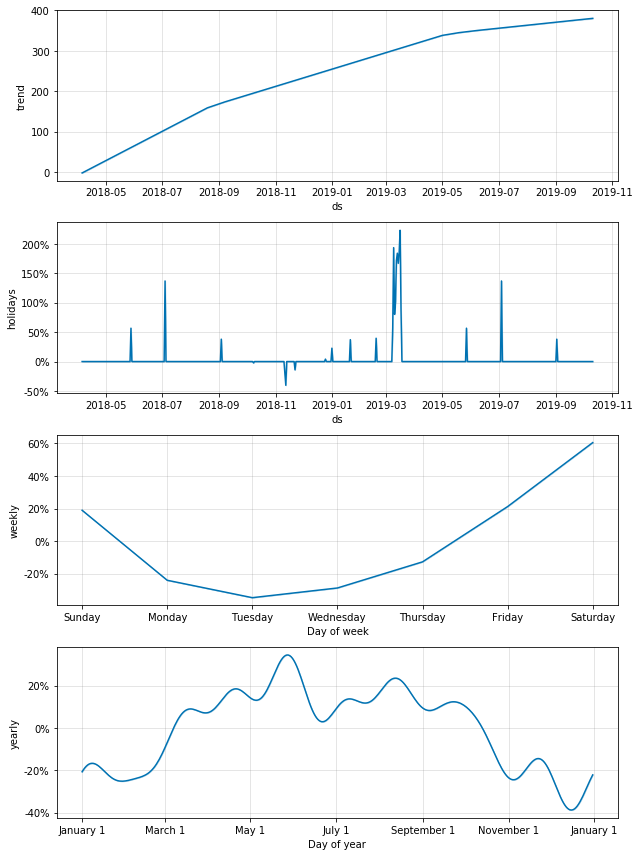

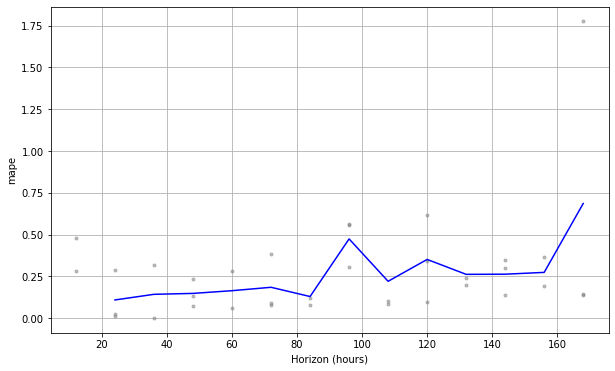

In [120]:
forecasts = pd.DataFrame()

for idx, ct in enumerate(census_starts.head(10).index.values):
    fbp, performance, df_cv, forecast = prophesy(ct, sample_rate='D')
    
    forecast = forecast.set_index('ds')
    forecasts[ct] = forecast['yhat']

In [134]:
# Create a dataf
future = forecasts.loc[pd.to_datetime('2019-9-10'):pd.to_datetime('2019-10-11')].fillna(0).clip(lower=0)
future_percent = future.div(future.sum(axis=1), axis=0)

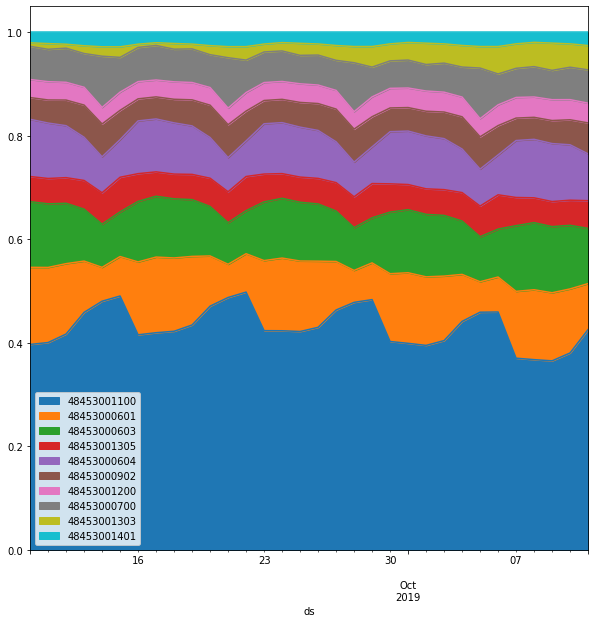

In [140]:
# register matplotlib converters.  This is a workaround for prophet working with pandas and matplotlib
# https://github.com/pandas-dev/pandas/issues/27036 for details.  Future pandas/prophet versions may resolve.
pd.plotting.register_matplotlib_converters()


# plot area for each 
future_percent.plot.area(stacked=True, figsize=(10,10))

In [141]:
future_percent

48453001100  48453000601  48453000603  48453001305  48453000604  \
ds                                                                            
2019-09-10     0.397067     0.148917     0.126871     0.048579     0.110532   
2019-09-11     0.400711     0.145073     0.122900     0.048956     0.107051   
2019-09-12     0.417124     0.135978     0.116615     0.049523     0.100377   
2019-09-13     0.458980     0.099100     0.100271     0.055463     0.083440   
2019-09-14     0.480561     0.065403     0.083313     0.060759     0.069442   
2019-09-15     0.490633     0.076203     0.086238     0.066925     0.072718   
2019-09-16     0.415687     0.140767     0.116866     0.053618     0.101895   
2019-09-17     0.419691     0.146127     0.117542     0.047044     0.102231   
2019-09-18     0.422507     0.141625     0.114166     0.047825     0.098935   
2019-09-19     0.434627     0.132514     0.109685     0.048715     0.093640   
2019-09-20     0.470995     0.096974     0.095578     0.054608     0.078596   
2019-09-21     0.487747     0.064159     0.080306     0.059756     0.066010   
2019-09-22     0.498167     0.074102     0.083137     0.066040     0.068732   
2019-09-23     0.423699     0.135337     0.113401     0.053768     0.097070   
2019-09-24     0.423489     0.140398     0.115434     0.047706     0.098475   
2019-09-25     0.422038     0.136142     0.113575     0.048595     0.096464   
2019-09-26     0.430106     0.127816     0.110519     0.049355     0.092657   
2019-09-27     0.463598     0.093687     0.097471     0.054875     0.078878   
2019-09-28     0.478318     0.061723     0.082606     0.059621     0.066963   
2019-09-29     0.483653     0.070960     0.086964     0.066241     0.070853   
2019-09-30     0.402735     0.130978     0.118969     0.054598     0.100748   
2019-10-01     0.399206     0.136297     0.121871     0.048579     0.103270   
2019-10-02     0.395227     0.132426     0.120647     0.049346     0.102234   
2019-10-03     0.404465     0.124614     0.117233     0.049782     0.098558   
2019-10-04     0.441596     0.090757     0.103116     0.054943     0.084163   
2019-10-05     0.459333     0.058831     0.086878     0.059292     0.071349   
2019-10-06     0.459693     0.067588     0.092560     0.066229     0.077075   
2019-10-07     0.370506     0.129066     0.126917     0.054436     0.110033   
2019-10-08     0.367695     0.135023     0.129607     0.047953     0.112983   
2019-10-09     0.365378     0.131494     0.127788     0.048408     0.112004   
2019-10-10     0.380599     0.123719     0.122841     0.048522     0.107028   
2019-10-11     0.425777     0.088819     0.106561     0.053593     0.090405   

            48453000902  48453001200  48453000700  48453001303  48453001401  
ds                                                                           
2019-09-10     0.041991     0.034884     0.064063     0.006759     0.020336  
2019-09-11     0.044615     0.035299     0.062558     0.011056     0.021781  
2019-09-12     0.049489     0.034311     0.065928     0.007601     0.023054  
2019-09-13     0.062191     0.034391     0.065170     0.014974     0.026021  
2019-09-14     0.063448     0.031885     0.098992     0.018166     0.028031  
2019-09-15     0.056523     0.035180     0.067155     0.020377     0.028047  
2019-09-16     0.042633     0.033212     0.066131     0.006219     0.022973  
2019-09-17     0.042607     0.032625     0.066685     0.005287     0.020162  
2019-09-18     0.045566     0.033692     0.063059     0.011055     0.021570  
2019-09-19     0.050371     0.033452     0.064913     0.009251     0.022831  
2019-09-20     0.062504     0.034064     0.063414     0.017503     0.025764  
2019-09-21     0.063588     0.031953     0.097412     0.021327     0.027743  
2019-09-22     0.057654     0.035775     0.062684     0.026013     0.027697  
2019-09-23     0.045012     0.034631     0.059091     0.015315     0.022675  
2019-09-24     0.044999     0.034522     0.058941     0.016117     0.019919  